Modelo acople SWMM-MODFLOW para ser verificado

# Import Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np
from numpy import *
from scipy.spatial import cKDTree
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
plt.rcParams["font.family"] = "Times New Roman"
import os
import platform
import sys
import math
import time
import re
from datetime import datetime

from pyswmm import Simulation, Nodes, Subcatchments, Links, SystemStats

import flopy
from flopy.discretization.structuredgrid import StructuredGrid
from flopy.utils import Raster
from flopy.utils.zonbud import ZoneBudget, read_zbarray


import geopandas as gpd
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from shapely.geometry import Point
import fiona

import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show_hist

from affine import Affine
from pyproj import Proj, transform
import folium
from folium import plugins
from folium import IFrame
import cartopy as cp
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import cartopy.io.img_tiles as cimgt

flopy is installed in C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\flopy


# Create MODFLOW model

## Create workspace directory, set path to MF executable, model name, etc.

In [2]:
modelname='VER'
if platform.system() == 'Windows': exe_name='mfnwt.exe'
if platform.system() == 'Darwin': exe_name='mfnwt'

workspace = 'VER_MF_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)
    
ml = flopy.modflow.Modflow(modelname, version='mfnwt', exe_name=exe_name, model_ws=workspace)

## DIS package: Temporal and Spatial Discretization

### Spatial Discretization

In [3]:
nlay = 1     #number of layers
nrows = 22  #number of rows
ncols = 27  #number of columns
W = 135     #model size (X)
B = 110     #model size (Y)
d = 20      #aquifer thickness
top = 0
bottom = -20

x_resolution = W/ncols    
y_resolution = B/nrows
z_resolution=d/nlay

delr = y_resolution
delc = x_resolution

print('model resolution: x=%sm, y=%sm' % (x_resolution,y_resolution))

model resolution: x=5.0m, y=5.0m


### Temporal Discrtization (Transient Configuration)

In [5]:
nper = 1
perlen = 1
nstp = 1
steady= False
#steady = True

Análisis de Sencibilidad: Al aumentar nstp, disminuye la cantidad de agua exfiltrada (Drenada) al modelo superficial. Pareciera ser que el modelo subterráneo "distribuye" mejor el agua entre las celdas.

In [6]:
dis = flopy.modflow.ModflowDis(
    ml, nlay=nlay, nrow=nrows, ncol=ncols,
    delr=delr, delc=delc, top=top, botm=bottom,
    nper=nper, perlen=perlen, nstp=nstp, steady=steady)

### Set spatial reference:

In [7]:
ml.modelgrid.set_coord_info(xoff=662916.664, yoff=5428317.527, angrot=0, epsg=32718)

In [8]:
ml.update_modelgrid()

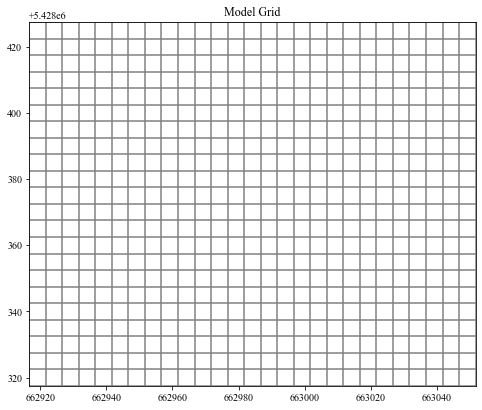

In [9]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=ml)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid()

t = ax.set_title("Model Grid")

Guardar la grilla como un shapefile:

In [10]:
ml.modelgrid.write_shapefile('GIS/Shapes/MODFLOW_VER_grid_flopy.shp')

wrote GIS/Shapes/MODFLOW_VER_grid_flopy.shp


In [11]:
MODFLOW_gdf=gpd.read_file('../GIS/Shapes/MODFLOW_VER_grid_flopy.shp')
MODFLOW_gdf.crs={'init': 'epsg:32718'}

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [12]:
MODFLOW_gdf

,node,row,column,geometry
0,1,1,1,"POLYGON ((662916.664 5428427.527, 662921.664 5..."
1,2,1,2,"POLYGON ((662921.664 5428427.527, 662926.664 5..."
2,3,1,3,"POLYGON ((662926.664 5428427.527, 662931.664 5..."
3,4,1,4,"POLYGON ((662931.664 5428427.527, 662936.664 5..."
4,5,1,5,"POLYGON ((662936.664 5428427.527, 662941.664 5..."
...,...,...,...,...
589,590,22,23,"POLYGON ((663026.664 5428322.527, 663031.664 5..."
590,591,22,24,"POLYGON ((663031.664 5428322.527, 663036.664 5..."
591,592,22,25,"POLYGON ((663036.664 5428322.527, 663041.664 5..."
592,593,22,26,"POLYGON ((663041.664 5428322.527, 663046.664 5..."


Definimos los centroides de cada celda de la capa superior para hacer la georrferenciación celda-subcuenca evitando la superposición o doble conteo.

In [13]:
MODFLOW_centroid=gpd.GeoDataFrame()
MODFLOW_centroid["geometry"]=MODFLOW_gdf["geometry"].centroid
MODFLOW_centroid["node"]=MODFLOW_gdf["node"]
MODFLOW_centroid.crs = {'init': 'epsg:32718'}

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Apply Elevation

Importamos los shapes que definen condiciones de borde, iniciales, elevación, entre otros.

In [15]:
active_subcuenca_gdf=gpd.read_file('GIS/Shapes/SUBCUENCA_VER.shp')
active_humedal_gdf=gpd.read_file('GIS/Shapes/HUMEDAL_VER_X2.shp')
active_out_gdf=gpd.read_file('GIS/Shapes/OUT_X2.shp')

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

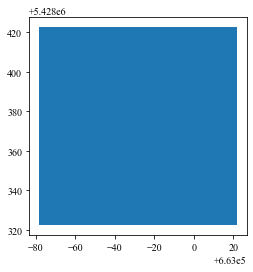

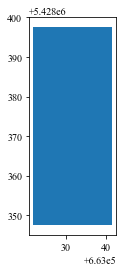

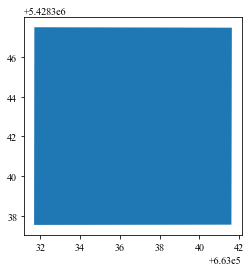

In [16]:
active_subcuenca_gdf.plot(), active_humedal_gdf.plot(), active_out_gdf.plot()

Georeferenciación de condiciones:

In [17]:
contained_actived_subcuenca_gdf=gpd.sjoin(MODFLOW_centroid, active_subcuenca_gdf, how="inner", op='intersects')
MODFLOW_gdf['active_s']=MODFLOW_gdf.index.isin(contained_actived_subcuenca_gdf.index.values.tolist())
contained_actived_humedal_gdf=gpd.sjoin(MODFLOW_centroid, active_humedal_gdf, how="inner", op='intersects')
MODFLOW_gdf['active_h']=MODFLOW_gdf.index.isin(contained_actived_humedal_gdf.index.values.tolist())
contained_out_gdf=gpd.sjoin(MODFLOW_gdf, active_out_gdf, how="inner", op='intersects')
MODFLOW_gdf['out']=MODFLOW_gdf.index.isin(contained_out_gdf.index.values.tolist())

In [18]:
MODFLOW_gdf

,node,row,column,geometry,active_s,active_h,out
0,1,1,1,"POLYGON ((662916.664 5428427.527, 662921.664 5...",False,False,False
1,2,1,2,"POLYGON ((662921.664 5428427.527, 662926.664 5...",False,False,False
2,3,1,3,"POLYGON ((662926.664 5428427.527, 662931.664 5...",False,False,False
3,4,1,4,"POLYGON ((662931.664 5428427.527, 662936.664 5...",False,False,False
4,5,1,5,"POLYGON ((662936.664 5428427.527, 662941.664 5...",False,False,False
...,...,...,...,...,...,...,...
589,590,22,23,"POLYGON ((663026.664 5428322.527, 663031.664 5...",False,False,False
590,591,22,24,"POLYGON ((663031.664 5428322.527, 663036.664 5...",False,False,False
591,592,22,25,"POLYGON ((663036.664 5428322.527, 663041.664 5...",False,False,False
592,593,22,26,"POLYGON ((663041.664 5428322.527, 663046.664 5...",False,False,False


In [19]:
MODFLOW_gdf['top']=0

In [20]:
MODFLOW_gdf.loc[MODFLOW_gdf.active_s == True, 'top'] = 0
MODFLOW_gdf.loc[MODFLOW_gdf.active_h == True, 'top'] = -2 #este valor debe coincidir con la profundidad del humedal
MODFLOW_gdf.loc[MODFLOW_gdf.out == True, 'top'] = -2.5

Contrucción de la matriz "top" para DIS package:

In [21]:
top = np.ones((nlay,nrows,ncols)) 

for index, row in MODFLOW_gdf.iterrows():
    top[:,row['row']-1,row['column']-1] = row['top']
top

array([[[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,

### Create DIS package object

In [22]:
dis = flopy.modflow.ModflowDis(
    ml, nlay=nlay, nrow=nrows, ncol=ncols,
    delr=delr, delc=delc, top=top, botm=bottom,
    nper=nper, perlen=perlen, nstp=nstp, steady=steady)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


[<AxesSubplot:title={'center':' model_top'}>,
 <AxesSubplot:title={'center':'botm layer 1'}>,
 <AxesSubplot:title={'center':'thickness layer 1'}>]

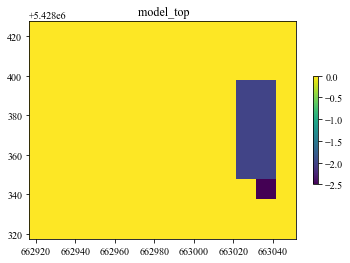

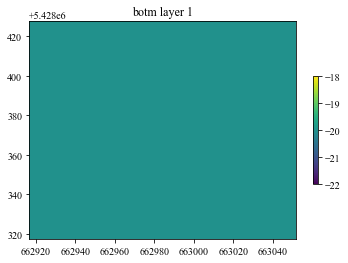

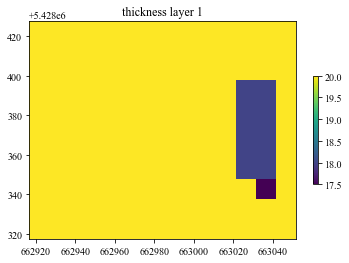

In [23]:
dis.plot()

## BAS package: Active model area and (boundry conditions?)

Condiciones de Borde extremo derecho (LAGO)

In [24]:
BC_lago_gdf=gpd.read_file('GIS/Shapes/LAGO_VER.shp')
contained_BC_lago_gdf=gpd.sjoin(MODFLOW_centroid, BC_lago_gdf, how="inner", op='intersects')
MODFLOW_gdf['BC_lago']=MODFLOW_gdf.index.isin(contained_BC_lago_gdf.index.values.tolist())

In [25]:
MODFLOW_gdf['ibound']=0
MODFLOW_gdf.head()

,node,row,column,geometry,active_s,active_h,out,top,BC_lago,ibound
0,1,1,1,"POLYGON ((662916.664 5428427.527, 662921.664 5...",False,False,False,0.0,False,0
1,2,1,2,"POLYGON ((662921.664 5428427.527, 662926.664 5...",False,False,False,0.0,False,0
2,3,1,3,"POLYGON ((662926.664 5428427.527, 662931.664 5...",False,False,False,0.0,False,0
3,4,1,4,"POLYGON ((662931.664 5428427.527, 662936.664 5...",False,False,False,0.0,False,0
4,5,1,5,"POLYGON ((662936.664 5428427.527, 662941.664 5...",False,False,False,0.0,False,0


In [26]:
MODFLOW_gdf.loc[MODFLOW_gdf.active_s == True, 'ibound'] = 1
MODFLOW_gdf.loc[MODFLOW_gdf.active_h == True, 'ibound'] = 1
MODFLOW_gdf.loc[MODFLOW_gdf.BC_lago == True, 'ibound'] = -1
MODFLOW_gdf.loc[MODFLOW_gdf.out == True, 'ibound'] = 1

In [27]:
MODFLOW_gdf

,node,row,column,geometry,active_s,active_h,out,top,BC_lago,ibound
0,1,1,1,"POLYGON ((662916.664 5428427.527, 662921.664 5...",False,False,False,0.0,False,0
1,2,1,2,"POLYGON ((662921.664 5428427.527, 662926.664 5...",False,False,False,0.0,False,0
2,3,1,3,"POLYGON ((662926.664 5428427.527, 662931.664 5...",False,False,False,0.0,False,0
3,4,1,4,"POLYGON ((662931.664 5428427.527, 662936.664 5...",False,False,False,0.0,False,0
4,5,1,5,"POLYGON ((662936.664 5428427.527, 662941.664 5...",False,False,False,0.0,False,0
...,...,...,...,...,...,...,...,...,...,...
589,590,22,23,"POLYGON ((663026.664 5428322.527, 663031.664 5...",False,False,False,0.0,False,0
590,591,22,24,"POLYGON ((663031.664 5428322.527, 663036.664 5...",False,False,False,0.0,False,0
591,592,22,25,"POLYGON ((663036.664 5428322.527, 663041.664 5...",False,False,False,0.0,False,0
592,593,22,26,"POLYGON ((663041.664 5428322.527, 663046.664 5...",False,False,False,0.0,False,0


Create ibound array

In [28]:
ibound = np.ones((nlay,nrows,ncols)) 

for index, row in MODFLOW_gdf.iterrows():
    ibound[:,row['row']-1,row['column']-1] = row['ibound']

In [29]:
ibound

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
          0., -1., -1.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
          0., -1., -1.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
          0., -1., -1.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
          0., -1., -1.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
          0., -1., -1.],
        [ 0.,  1.,  1.

### Set initial conditions (strt)

Se definen condiciones iniciales siendo coherentes con las condiciones iniciales del modelo superficial (en la unidad de almacenamiento)

In [30]:
strt=-2

### Create BAS package object

In [31]:
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)

[<AxesSubplot:title={'center':'ibound layer 1'}>,
 <AxesSubplot:title={'center':'strt layer 1'}>]

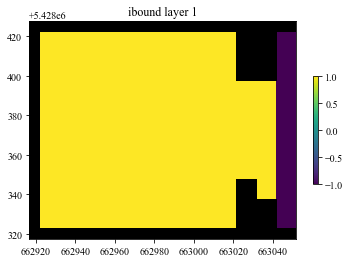

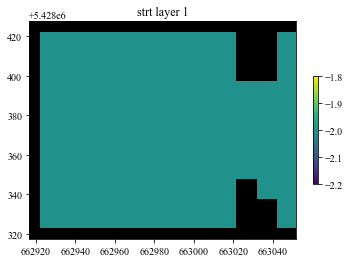

In [32]:
bas.plot()

## UPW package: Specify properties controlling flow between cells in MODFLOW-NWT

Parámetros hidráulicos del acuífero coinciden con los definidos para la subcuenca. Estos corresponden a Marga Limosa (K=1.8 E-6 m/s).

Se define ipakcb=53 para generar el archivo .cbc (Zone Bubget)

In [33]:
upw = flopy.modflow.ModflowUpw(ml, hk=0.156, sy=0.25, laytyp=1, iphdry=0, ipakcb=53)

## RCH package (will be modified on the loop)

## DRN package

In [34]:
MODFLOW_gdf['DRN']=False
MODFLOW_gdf.loc[MODFLOW_gdf.active_h == True, 'DRN'] = True
MODFLOW_gdf.loc[MODFLOW_gdf.out == True, 'DRN'] = True

In [35]:
MODFLOW_gdf_DRAINS=MODFLOW_gdf.loc[MODFLOW_gdf['DRN'] ==  True]

In [36]:
MODFLOW_gdf_DRAINS.active_h.unique()

array([ True, False])

Conductancia definida coincide con los parámetros hidráulicos de Green Ampt para el fondo de la unidad de almacenamiento. Marga arcillo-limosa (K= 2.8 E-7 m/s). Se considera que el agua aflora cuando supera la topografía (DRN_burn_depth=0). Se supone un espesor de sedimentos en el fondo del humedal de 1 m.

In [37]:
# Burn drains 1m into the DEM
DRN_burn_depth=0.

# Global parameters needed to calculate drain conductance (see reference MODELMUSE DRN package pane)
DRN_L = x_resolution 
DRN_W = y_resolution
DRN_M = 1
DRN_K = 0.024 #m/dia

DRN_C=DRN_K*DRN_L*DRN_W/DRN_M


DRN_stress_period_data=[]

for index,row in MODFLOW_gdf_DRAINS.iterrows():
    new_row=[0,row["row"]-1,row["column"]-1,row["top"]-DRN_burn_depth,DRN_C]
    DRN_stress_period_data.append(new_row)
#DRN_stress_period_data

In [38]:
drn = flopy.modflow.ModflowDrn(ml, stress_period_data=DRN_stress_period_data,ipakcb=53)

[<AxesSubplot:title={'center':' DRN location stress period 1 layer 1'}>]

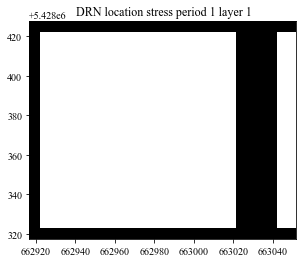

In [39]:
drn.plot()

## EVT Externa

Modificar esta tasa en cada paso de tiempo, dentro del loop, entrar a una lista con tasas diarias/mensuales.

In [40]:
EVTR=0.5 #(mm/d)
EVTR=0.5/1000 #(m/d)
EXPD=10 #m

Determinación de celdas a que evaporan

Podría hacer esto mismo para la infiltración y para las celdas drn!!!!!

In [42]:
PERV_subcuenca_gdf=gpd.read_file('GIS/Shapes/PERV_VER.shp')

In [43]:
contained_PERV_subcuenca_gdf=gpd.sjoin(MODFLOW_centroid, PERV_subcuenca_gdf, how="inner", op='intersects')
MODFLOW_gdf['PERV']=MODFLOW_gdf.index.isin(contained_actived_subcuenca_gdf.index.values.tolist())
MODFLOW_gdf["EVT"]=0
MODFLOW_gdf.loc[MODFLOW_gdf.PERV == True, 'EVT'] = 1

In [44]:
MODFLOW_gdf

,node,row,column,geometry,active_s,active_h,out,top,BC_lago,ibound,DRN,PERV,EVT
0,1,1,1,"POLYGON ((662916.664 5428427.527, 662921.664 5...",False,False,False,0.0,False,0,False,False,0
1,2,1,2,"POLYGON ((662921.664 5428427.527, 662926.664 5...",False,False,False,0.0,False,0,False,False,0
2,3,1,3,"POLYGON ((662926.664 5428427.527, 662931.664 5...",False,False,False,0.0,False,0,False,False,0
3,4,1,4,"POLYGON ((662931.664 5428427.527, 662936.664 5...",False,False,False,0.0,False,0,False,False,0
4,5,1,5,"POLYGON ((662936.664 5428427.527, 662941.664 5...",False,False,False,0.0,False,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,590,22,23,"POLYGON ((663026.664 5428322.527, 663031.664 5...",False,False,False,0.0,False,0,False,False,0
590,591,22,24,"POLYGON ((663031.664 5428322.527, 663036.664 5...",False,False,False,0.0,False,0,False,False,0
591,592,22,25,"POLYGON ((663036.664 5428322.527, 663041.664 5...",False,False,False,0.0,False,0,False,False,0
592,593,22,26,"POLYGON ((663041.664 5428322.527, 663046.664 5...",False,False,False,0.0,False,0,False,False,0


## OC package

In [45]:
spd = {(0,0): ['save head', 'save budget'], (1,0): ['save head', 'save budget']}
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd) 

## NWT package

In [46]:
nwt = flopy.modflow.ModflowNwt(ml)

## Checks, run model, read outputs, plots

In [47]:
ml.get_package_list()

['DIS', 'BAS6', 'UPW', 'DRN', 'OC', 'NWT']

In [48]:
ml.check()


VER MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    UPW package: vertical hydraulic conductivity values below checker threshold of 1e-11

In [49]:
ml.write_input()

## Zone Budget:

In [50]:
MODFLOW_gdf["zon"]=5
MODFLOW_gdf.loc[MODFLOW_gdf.active_s == True, 'zon'] = 1
MODFLOW_gdf.loc[MODFLOW_gdf.active_h == True, 'zon'] = 2
MODFLOW_gdf.loc[MODFLOW_gdf.BC_lago == True, 'zon'] = 3
MODFLOW_gdf.loc[MODFLOW_gdf.out == True, 'zon'] = 4

In [51]:
zon = np.zeros((nlay,nrows,ncols)) 

for index, row in MODFLOW_gdf.iterrows():
    zon[:,row['row']-1,row['column']-1] = row['zon']

zon=zon[0].astype(np.int64)

In [52]:
aliases = {1: 'S1', 2:'SU', 3: 'Lake', 4: 'OUT' ,5: 'Inactive' }

In [53]:
ZB_TS=[]

<AxesSubplot:>

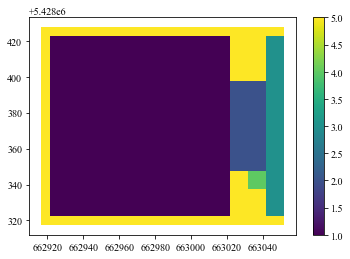

In [54]:
MODFLOW_gdf.plot(column="zon", legend=True)

# Load SWMM model

Importación del archivo inp SWMM. 

In [55]:
dire="SWMM_VER_model"
file="SWMM_VER_X2.inp"
path=dire + "/" + file

Nota: se está considerando una tasa de evapotranspiración constante igual a 0.5 mm/día

In [56]:
dt=300. #[s]

# SWMM and MODFLOW coupling

## Map subcatchments to cells

In [57]:
MODFLOW_gdf['SWMM_S']=np.NaN
MODFLOW_gdf.loc[MODFLOW_gdf.active_s == True, 'SWMM_S'] = "S1"
MODFLOW_gdf.loc[MODFLOW_gdf.active_h == True, 'SWMM_S'] = "S2"

## Map storage units to cells

In [58]:
MODFLOW_gdf['SWMM_SU']=np.NaN
MODFLOW_gdf.loc[MODFLOW_gdf.active_h == True, 'SWMM_SU'] = "SU1"

## Map drain cells to nodes or storage units

In [59]:
MODFLOW_gdf

,node,row,column,geometry,active_s,active_h,out,top,BC_lago,ibound,DRN,PERV,EVT,zon,SWMM_S,SWMM_SU
0,1,1,1,"POLYGON ((662916.664 5428427.527, 662921.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
1,2,1,2,"POLYGON ((662921.664 5428427.527, 662926.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
2,3,1,3,"POLYGON ((662926.664 5428427.527, 662931.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
3,4,1,4,"POLYGON ((662931.664 5428427.527, 662936.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
4,5,1,5,"POLYGON ((662936.664 5428427.527, 662941.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,590,22,23,"POLYGON ((663026.664 5428322.527, 663031.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
590,591,22,24,"POLYGON ((663031.664 5428322.527, 663036.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
591,592,22,25,"POLYGON ((663036.664 5428322.527, 663041.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN
592,593,22,26,"POLYGON ((663041.664 5428322.527, 663046.664 5...",False,False,False,0.0,False,0,False,False,0,5,NaN,NaN


## Loop for Temporal/Spatial Data Exchange

In [60]:
TS_gdf=[]

In [61]:
#SWMM Subcatchments names:
S_names_list=["S1", "S2"]
#SWMM Storge Unites names:
SU_names_list=["SU1"]
#Wetlands subcatchments
SU_S_names_list=["S2"]

Las unidades definidas a continuación consideran que el modelo SWMM está en CMS.

In [62]:
S_SWMM_TS=[]
SU_SWMM_TS=[]
for i in S_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Precipitation (mm/h)"]=""
    a["Evaporation (mm/d)"]=""
    a["Infiltration (mm/h)"]="" 
    a["Runoff (m3/s)"]=""
    a["Runon (m3/s)"]=""
    a["Cumulative Infiltration (m3)"]=""
    a["Cumulative Evaporation (m3)"]=""
    S_SWMM_TS.append(a)
for i in SU_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    a["Volume (m3)"]=""
    a["Losses (m3/s)"]=""
    a["Cumulative Exfiltration Loss (m3)"]=""
    a["Cumulative Evaporation Loss (m3)"]=""
    SU_SWMM_TS.append(a)

In [63]:
with Simulation(path) as sim:
    if not sim.flow_units=="CMS":
        print("SWMM flow units must be CMS")

In [64]:
with Simulation(path) as sim:
    S_areas=[]
    system_routing = SystemStats(sim)
    for s in S_names_list:
        S_areas.append(Subcatchments(sim)[s].area) #[ha]  

In [65]:
S_areas_cells=MODFLOW_gdf.groupby("SWMM_S").count()["node"]*x_resolution*y_resolution

In [66]:
S_areas_cells

SWMM_S
S1    10000.0
S2     1000.0
Name: node, dtype: float64

In [67]:
S_areas

[1.0, 0.1]

In [68]:
with Simulation(path) as sim:
    print(sim.flow_units)
    S_list=[]
    SU_list=[]
    S_areas=[]
    system_routing = SystemStats(sim)
    
    for s in S_names_list:
        S_list.append(Subcatchments(sim)[s])
        S_areas.append(Subcatchments(sim)[s].area) #[ha]  
    for i in range(len(SU_names_list)):
        SU_list.append(Nodes(sim)[SU_names_list[i]])
    
    inf_S_list_1=np.zeros(len(S_list))
    inf_S_list_2=np.zeros(len(S_list))
    inf_SU_list_1=np.zeros(len(SU_list))
    inf_SU_list_2=np.zeros(len(SU_list))
    
    #lists for the DRN incorporation
    rate_SU_list=np.zeros(len(SU_list))
    
    #time counter for agregation
    step_counter=0
    day_counter=0
    hourly_counter=0
    
    for step in sim:
        step_counter=step_counter+1
        
        #rainfall modification to avoid double counting
        
        if step_counter==12:
            step_counter=0
            hourly_counter+=1
            #SUBCATCHMENTS TIME SERIES RESULTS
            for i in range(len(S_list)):
                new_row = {'Time': sim.current_time, "Precipitation (mm/h)":S_list[i].rainfall, 
                           "Evaporation (mm/d)":S_list[i].evaporation_loss,"Infiltration (mm/h)":S_list[i].infiltration_loss, 
                           "Runoff (m3/s)":S_list[i].runoff,"Runon (m3/s)":S_list[i].runon,
                           "Cumulative Infiltration (m3)": S_list[i].statistics["infiltration"], "Cumulative Evaporation (m3)": S_list[i].statistics["evaporation"]}
                S_SWMM_TS[i] =S_SWMM_TS[i].append(new_row, ignore_index=True)

            #STORAGE UNITS TIME SERIES RESULTS
            for i in range(len(SU_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":SU_list[i].depth, 
                           "Head (m)":SU_list[i].head, "Flooding (m3/s)":SU_list[i].flooding, 
                           "Lateral inflow (m3/s)":SU_list[i].lateral_inflow,"Total inflow (m3/s)":SU_list[i].total_inflow,
                           "Total outflow (m3/s)":SU_list[i].total_outflow, "Volume (m3)":SU_list[i].volume, "Losses (m3/s)":SU_list[i].losses,
                           "Cumulative Exfiltration Loss (m3)": SU_list[i].storage_statistics["exfil_loss"], "Cumulative Evaporation Loss (m3)": SU_list[i].storage_statistics["evap_loss"]}
                SU_SWMM_TS[i] =SU_SWMM_TS[i].append(new_row, ignore_index=True)
            
        if hourly_counter==24:
            day_counter=day_counter+1
            hourly_counter=0
            print(sim.current_time)
            for i in range(len(SU_list)):
                #Delta infiltration
                inf_SU_list_2[i]=(SU_list[i].storage_statistics["exfil_loss"]-inf_SU_list_1[i])
                inf_SU_list_1[i]=SU_list[i].storage_statistics["exfil_loss"]
           
            for i in range(len(S_list)):
                #Delta infiltration
                inf_S_list_2[i]=(S_list[i].statistics["infiltration"]-inf_S_list_1[i])
                inf_S_list_1[i]=S_list[i].statistics["infiltration"]
                
            RCH_S=inf_S_list_2
            RCH_SU=np.zeros(len(S_names_list))
            for i in range(len(S_names_list)):
                for j in range(len(SU_S_names_list)):
                    if S_names_list[i]==SU_S_names_list[j]:
                        RCH_SU[i]=inf_SU_list_2[j]
            RCH=RCH_S+RCH_SU
            
            #Unit change m3/dia->m/dia:
            RCH_m=RCH/(np.array(S_areas)*10000.) #[m/dia]
            RCH_df=pd.DataFrame({"SWMM_S":S_names_list, "RCH":RCH_m})
            
            #Gereferenced RCH: Add to the MODFLOW_gdf new column of rch
            MODFLOW_gdf_test=pd.DataFrame() #en cada pasa de tiempo se crea uno nuevo, lo agrego en TS_gdf
            MODFLOW_gdf_test=pd.merge(MODFLOW_gdf, RCH_df, on="SWMM_S", how="left")
            
            #Create MODFLOW inputs: RCH package
            rch_array = np.zeros((nrows,ncols))
            recharge_cells = MODFLOW_gdf_test.index.values
            for cell in recharge_cells:
                row = MODFLOW_gdf_test.row[cell]
                col = MODFLOW_gdf_test.column[cell]
                flux = MODFLOW_gdf_test.RCH[cell]
                rch_array[row - 1][col - 1] = flux
            rch_array[np.isnan(rch_array)] = 0.
        
            rch = flopy.modflow.ModflowRch(ml, nrchop=3, rech=rch_array, ipakcb=53)
            
            bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt) #use the head table of the last time step
           
            #Run MODFLOW
            
            ml.write_input()
            ml.run_model(silent=True)
            
            #Read MODFLOW outputs
            fname = os.path.join('VER_MF_workspace', 'VER.hds')
            headfile = flopy.utils.HeadFile(fname, model=ml)
            heads = headfile.get_data()
            heads[heads==1.e+30] = np.nan            # fix masked data 
            heads[heads==-999.99] = np.nan

            
            top = ml.dis.top.array
            DTWT = top-heads[0]
            
            #DRN calculate
            H=np.reshape(DTWT, len(MODFLOW_gdf_test))
            altura=np.reshape(heads[0], len(MODFLOW_gdf_test))
            for i in range(len(H)):
                if H[i]<0:
                    H[i]=-H[i]
                else:
                     H[i]=0.
            MODFLOW_gdf_test["Altura"]=altura   
            MODFLOW_gdf_test["H"]=H
            MODFLOW_gdf_test["DRN_rate"]=0.
            
            for i in  range(len(MODFLOW_gdf_test["DRN"])):
                if MODFLOW_gdf_test["DRN"][i]:
                    MODFLOW_gdf_test["DRN_rate"][i]=H[i]*DRN_C
            
            #inflow rate array for wetlands:
            W_inflow=MODFLOW_gdf_test.groupby("SWMM_SU").sum()["DRN_rate"]  #m3/dia
            inflow_in_w=[]
            for w in SU_names_list:
                if w in W_inflow.index:
                    inflow_in_w.append(W_inflow[w])
                else:
                    inflow_in_w.append(0.)        
                
            #Generated inflow swmm wetlands
            
            for i in range(len(SU_list)):
                rate=inflow_in_w[i]/86400. #m3/s
                SU_list[i].generated_inflow(rate)
            
            #MODFLOW evaporation on perv cells
            
            MODFLOW_gdf_test["RET"]=0
            MODFLOW_gdf_test.loc[MODFLOW_gdf_test.Altura<(MODFLOW_gdf["top"]-EXPD), 'RET']=0
            MODFLOW_gdf_test.loc[MODFLOW_gdf_test.Altura>(MODFLOW_gdf["top"]-EXPD), 'RET'] = MODFLOW_gdf["EVT"]*EVTR*(MODFLOW_gdf_test["Altura"]-(MODFLOW_gdf["top"]-EXPD))/EXPD
            MODFLOW_gdf_test.loc[MODFLOW_gdf_test.Altura>MODFLOW_gdf["top"], 'RET'] = EVTR*MODFLOW_gdf["EVT"]      
            
            MODFLOW_gdf_test["Altura_EVT"]=MODFLOW_gdf_test["Altura"]-MODFLOW_gdf_test["RET"]
            
            #Strt next loop
            strt = np.ones((nlay,nrows,ncols)) 
            for index, row in MODFLOW_gdf_test.iterrows():
                strt[:,row['row']-1,row['column']-1] = row["Altura_EVT"]
                     
            #Save MODFLOW cells information
            TS_gdf.append(MODFLOW_gdf_test)
            
            #check if al the drain water is incoporporated to SWMM as inflow:
            total_DRN_MODFLOW_model=MODFLOW_gdf_test.DRN_rate.sum()
            total_DRN_SWMM_model=MODFLOW_gdf_test.groupby("SWMM_S").sum().DRN_rate.sum()
            total_inflow=sum(inflow_in_w)
            if total_DRN_MODFLOW_model>total_inflow:
                print("WARNING: There is drained water outside the SWMM model area")
            if total_DRN_SWMM_model>total_inflow:
                print("ERROR: There is drained water on the SWMM model area that is not inflow")
            
            #Save zonebudget DataFrame
            fname = os.path.join('VER_MF_workspace', 'VER.cbc')
            cbb = flopy.utils.CellBudgetFile(fname)
            zb = flopy.utils.ZoneBudget(cbb, zon, aliases=aliases)
            zb_df=zb.get_dataframes()
            ZB_TS.append(zb_df)
            
    routing_stats=system_routing.routing_stats
    runoff_stats=system_routing.runoff_stats     
print("Flow Routing Mass Balance Error:", sim.flow_routing_error)
print("Runoff Mass Balance Error:", sim.runoff_error) 

CMS
2018-08-02 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-03 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-04 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-05 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-06 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-07 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-08 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-09 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-10 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-11 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-12 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-13 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-14 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-15 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-16 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-17 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-18 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-19 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-20 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-21 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-22 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-23 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-24 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-25 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-26 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-27 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-28 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-29 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-30 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-08-31 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-01 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-02 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-03 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-04 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-05 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-06 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-07 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-08 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-09 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-10 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-11 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-12 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-13 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-14 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-15 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-16 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-17 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-18 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-19 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-20 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-21 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-22 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-23 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-24 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-25 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-26 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-27 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-28 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-29 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-09-30 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-01 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-02 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-03 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-04 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-05 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-06 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-07 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-08 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-09 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-10 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-11 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-12 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-13 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-14 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-15 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-16 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-17 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-18 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-19 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-20 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-21 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-22 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-23 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-24 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-25 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2018-10-26 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-27 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-28 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-29 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-30 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-10-31 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-01 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-02 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-03 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-04 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-05 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-06 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-07 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-08 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-09 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-10 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-11 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-12 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-13 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-14 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-15 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-16 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-17 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-18 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-19 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-20 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2018-11-21 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-22 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-23 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-24 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-25 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-26 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-27 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-28 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-29 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-11-30 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018-12-01 00:00:00
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
Flow Routing Mass Balance Error: 0.0
Runoff Mass Balance Error: 0.0


C:\Users\tibun\Anaconda3\envs\acople\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
df_routing_couple = pd.DataFrame({'Dry Weather Inflow (m3)': [routing_stats['dry_weather_inflow']],
                   'Wet Weather Inflow (m3)': [routing_stats['wet_weather_inflow']], 
                   'Ground Water Inflow (m3)': [routing_stats['groundwater_inflow']],
                   #'RDII Inflow (m3)': [routing_stats['II_inflow']],
                   'External Inflow (m3)': [routing_stats['external_inflow']],
                   'External Outflow (m3)': [routing_stats['outflow']],
                   'Flooding Loss (m3)': [routing_stats['flooding']],
                   'Evaporation Loss (m3)': [routing_stats['evaporation_loss']],
                   'Seepage Loss (m3)': [routing_stats['seepage_loss']],
                   'Initial Stored Volume': [routing_stats['initial_storage']],
                   'Final Stored Volume': [routing_stats['final_storage']],
                   'Continuity Error (%)': [routing_stats['routing_error']]})

In [70]:
df_runoff_couple = pd.DataFrame({'Total Precipitation (mm)': [runoff_stats['rainfall']],
                   'Evaporation Loss (m3)': [runoff_stats['evaporation']], 
                   'Infiltration Loss (m3)': [runoff_stats['infiltration']],
                   'Runoff (m3)': [runoff_stats['runoff']],
                   "Initial Storage (mm)":[runoff_stats['init_storage']],
                   "Final Storage (mm)":[runoff_stats['final_storage']]})

In [71]:
df_routing_couple

,Dry Weather Inflow (m3),Wet Weather Inflow (m3),Ground Water Inflow (m3),External Inflow (m3),External Outflow (m3),Flooding Loss (m3),Evaporation Loss (m3),Seepage Loss (m3),Initial Stored Volume,Final Stored Volume,Continuity Error (%)
0,0.0,2705.668666,0.0,1755.152484,0.0,0.0,0.0,3546.974701,0.0,0.0,0.0


In [72]:
df_runoff_couple

,Total Precipitation (mm),Evaporation Loss (m3),Infiltration Loss (m3),Runoff (m3),Initial Storage (mm),Final Storage (mm)
0,334.5,137.975622,836.343486,2705.668666,0.0,0.0


# Results

## Zone Budget

In [74]:
ZB_TS[0]=ZB_TS[0].reset_index(level=[0,1])

In [75]:
dias=np.linspace(0,len(ZB_TS)-1,len(ZB_TS))
df_S1_ZB=pd.DataFrame(index=dias)
df_SU_ZB=pd.DataFrame(index=dias)
df_Lake_ZB=pd.DataFrame(index=dias)
df_OUT_ZB=pd.DataFrame(index=dias)
columnas=ZB_TS[0].name
for i in columnas:
    df_S1_ZB[i]=""
    df_SU_ZB[i]=""
    df_Lake_ZB[i]=""
    df_OUT_ZB[i]=""

In [76]:
for i in range(len(ZB_TS)):
    for j in range(len(columnas)):
        df_S1_ZB[columnas[j]][i]=ZB_TS[i].iloc[j].S1
        df_SU_ZB[columnas[j]][i]=ZB_TS[i].iloc[j].SU
        df_OUT_ZB[columnas[j]][i]=ZB_TS[i].iloc[j].OUT
        df_Lake_ZB[columnas[j]][i]=ZB_TS[i].iloc[j].Lake

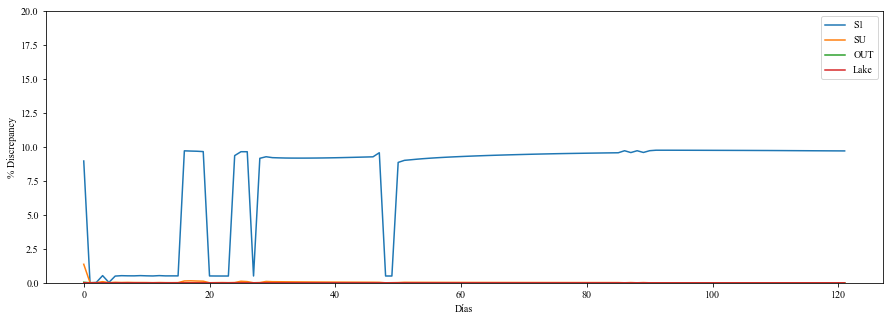

In [77]:
df_S1_ZB["PERCENT_DISCREPANCY"].plot(figsize=(15,5))
df_SU_ZB["PERCENT_DISCREPANCY"].plot()
df_OUT_ZB["PERCENT_DISCREPANCY"].plot()
df_Lake_ZB["PERCENT_DISCREPANCY"].plot()
plt.legend(["S1","SU","OUT", "Lake"])
plt.ylabel("% Discrepancy")
plt.xlabel("Días")
plt.ylim(0,20)
plt.show()

## Continuity Analysis

Usando TS_gdf:

In [78]:
W_inflow=[]
S_rch=[]
W_rch=[]
for i in range(len(TS_gdf)):
    rch=TS_gdf[i].groupby("SWMM_S").sum()["RCH"]
    W_rch.append(rch.S2*x_resolution*y_resolution)
    S_rch.append(rch.S1*x_resolution*y_resolution)
for i in range(len(TS_gdf)):
    inflow=TS_gdf[i].groupby("SWMM_SU").sum()["DRN_rate"]
    W_inflow.append(inflow.SU1)
    
total_S_rch=sum(S_rch)
total_W_rch=sum(W_rch)
total_W_inflow=sum(W_inflow)
dt_drn_m=inflow.SU1

print(total_S_rch, "m3")
print(total_W_rch, "m3")
print(total_W_inflow, "m3")
print(dt_drn_m, "m3")

836.343486191457 m3
3546.930768520382 m3
1768.3554103374481 m3
13.225888180732726 m3


In [79]:
len(TS_gdf)

122

In [80]:
len(df_S1_ZB)

122

### Coupling Continuity

Cálculo external inflow usando SWMM output

In [81]:
E_in_s=df_routing_couple["External Inflow (m3)"][0]
E_in_s

1755.1524837678403

Cálculo agua drenada usando MODFLOW output (ZB):

In [82]:
DRN_S_M=df_SU_ZB["TO_DRAINS"].sum()-dt_drn_m
DRN_S_M

1755.1298247098923

In [83]:
DRN_ext_m=df_OUT_ZB["TO_DRAINS"].sum()
DRN_ext_m

158.6433

In [84]:
DRN_m=df_OUT_ZB["TO_DRAINS"].sum()+df_SU_ZB["TO_DRAINS"].sum()
DRN_m

1926.999

In [85]:
error_drn_inflow=((DRN_S_M)-E_in_s)/(DRN_S_M)*100
print("Continuity Coupling Error(DRN/INFLOW):",error_drn_inflow,"%")

Continuity Coupling Error(DRN/INFLOW): -0.0012910189109071476 %


Cálculo infiltración total usando SWMM output

In [86]:
df_runoff_couple["Infiltration Loss (m3)"][0]

836.343486191458

In [87]:
df_routing_couple["Seepage Loss (m3)"][0]

3546.974701255031

In [88]:
I_s=df_runoff_couple["Infiltration Loss (m3)"][0]
I_s

836.343486191458

In [89]:
S_s=df_routing_couple["Seepage Loss (m3)"][0]
S_s

3546.974701255031

Cálculo recarga usando MODFLOW output (ZB):

In [90]:
df_SU_ZB["FROM_RECHARGE"].sum()

3546.9304

In [91]:
df_S1_ZB["FROM_RECHARGE"].sum()

836.3436

In [92]:
RCH_m=df_S1_ZB["FROM_RECHARGE"].sum()+df_SU_ZB["FROM_RECHARGE"].sum()
RCH_m

4383.274

In [93]:
error_inf_rch=(RCH_m-I_s-S_s)/RCH_m*100
print("Continuity Coupling Error(INF/RCH):",error_inf_rch,"%")

Continuity Coupling Error(INF/RCH): -0.00100978551622467 %


### SWMM Continuity

In [94]:
P_s=df_runoff_couple["Total Precipitation (mm)"][0]*sum(S_areas)*10
P_s

3679.500000000034

In [95]:
E_out_s=df_routing_couple["External Outflow (m3)"][0]
E_out_s

0.0

In [96]:
E_out_s=df_routing_couple["External Outflow (m3)"][0]
E_out_s

0.0

In [97]:
F_s=df_routing_couple["Flooding Loss (m3)"][0]
F_s

0.0

In [98]:
S_f_s=914+0*sum(S_areas)*10
S_i_s=0
S_f_s

914.0

In [99]:
EVT_s=df_runoff_couple["Evaporation Loss (m3)"][0]+df_routing_couple["Evaporation Loss (m3)"][0]
EVT_s

137.97562159542193

In [101]:
SWMM_error=P_s+E_in_s-E_out_s-EVT_s-F_s-I_s-S_s-S_f_s+S_i_s
total_in_s=P_s+E_in_s
percent_SWMM_error=SWMM_error/total_in_s
print("SWMM Error:",percent_SWMM_error, "%" )

SWMM Error: -0.00011800667585511143 %


### MODFLOW Continuity

In [102]:
CH_out_m=df_Lake_ZB["TO_CONSTANT_HEAD"].sum()
CH_out_m

1313.9425

In [103]:
CH_in_m=df_Lake_ZB["FROM_CONSTANT_HEAD"].sum()
CH_in_m

5.898598

In [104]:
S_to_m=df_S1_ZB["TO_STORAGE"].sum()+df_SU_ZB["TO_STORAGE"].sum()+df_OUT_ZB["TO_STORAGE"].sum()
S_to_m

1178.0435

In [105]:
S_from_m=df_S1_ZB["FROM_STORAGE"].sum()+df_SU_ZB["FROM_STORAGE"].sum()+df_OUT_ZB["FROM_STORAGE"].sum()
S_from_m

6.081012

In [106]:
MODFLOW_error=RCH_m+CH_in_m-DRN_m-CH_out_m-S_to_m+S_from_m #m3
total_in_M=RCH_m+CH_in_m
percent_MODFLOW_error=MODFLOW_error/total_in_M*100
print("MODFLOW Error:",percent_MODFLOW_error, "%" )

MODFLOW Error: -0.5406852811574936 %


### Global Continuity

In [107]:
GLOBAL_error=P_s+CH_in_m-(DRN_ext_m+dt_drn_m)-E_out_s-EVT_s-CH_out_m-(S_to_m-S_from_m)-(S_f_s-S_i_s)
total_in=P_s+CH_in_m
percent_GLOBAL_error=GLOBAL_error/total_in*100
print("GLOBAL Error:",percent_GLOBAL_error, "%" )

GLOBAL Error: -0.6607457361214357 %


In [108]:
error_df=pd.DataFrame({"Coupling (DRN/INFLOW) % ": [error_drn_inflow], "Coupling (INF/RCH) %": [error_inf_rch], "SWMM %": [percent_SWMM_error], "MODFLOW %": [percent_MODFLOW_error], "Global %": [percent_GLOBAL_error]})

In [109]:
error_df

,Coupling (DRN/INFLOW) %,Coupling (INF/RCH) %,SWMM %,MODFLOW %,Global %
0,-0.001291,-0.00101,-0.000118,-0.540685,-0.660746


In [110]:
evp_cells_mdoflow=[]
for i in range(len(TS_gdf)):
    evp_day=TS_gdf[i].RET.sum()
    evp_cells_mdoflow.append(evp_day*x_resolution*y_resolution)

In [111]:
sum(evp_cells_mdoflow)

509.66644162535664

## Couple Model Results

### SWMM Subcatchments

Text(0, 0.5, 'Evaporation (mm/d)')

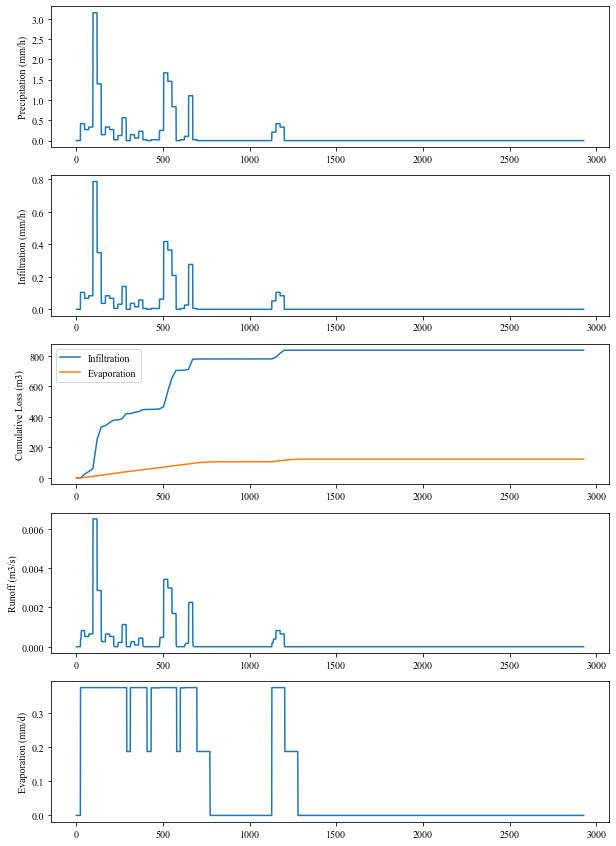

In [110]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10,15))
ax1.plot(S_SWMM_TS[0].index,S_SWMM_TS[0]["Precipitation (mm/h)"] )
ax1.set_ylabel("Precipitation (mm/h)")
ax2.plot(S_SWMM_TS[0].index,S_SWMM_TS[0]["Infiltration (mm/h)"] )
ax2.set_ylabel("Infiltration (mm/h)")
ax3.plot(S_SWMM_TS[0].index,S_SWMM_TS[0]["Cumulative Infiltration (m3)"], label="Infiltration")
ax3.plot(S_SWMM_TS[0].index,S_SWMM_TS[0]["Cumulative Evaporation (m3)"], label="Evaporation" )
ax3.set_ylabel("Cumulative Loss (m3)")
ax3.legend()
ax4.plot(S_SWMM_TS[0].index,S_SWMM_TS[0]["Runoff (m3/s)"] )
ax4.set_ylabel("Runoff (m3/s)")
ax5.plot(S_SWMM_TS[0].index,S_SWMM_TS[0]["Evaporation (mm/d)"] )
ax5.set_ylabel("Evaporation (mm/d)")

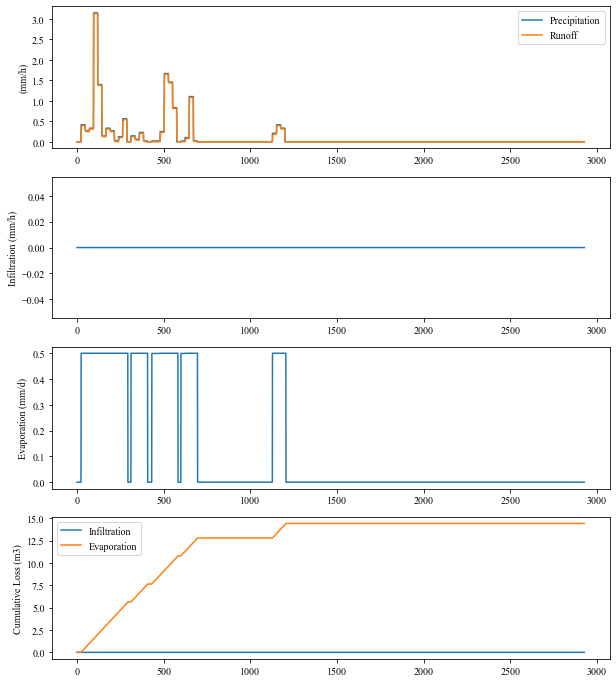

In [111]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,12))
ax1.plot(S_SWMM_TS[1].index,S_SWMM_TS[1]["Precipitation (mm/h)"], label="Precipitation" )
#ax1.set_ylabel("Precipitation (mm/h)")
ax1.plot(S_SWMM_TS[1].index,S_SWMM_TS[1]["Runoff (m3/s)"]/1000*1000*60*60 , label="Runoff")
ax1.set_ylabel("(mm/h)")
ax1.legend()
ax2.plot(S_SWMM_TS[1].index,S_SWMM_TS[1]["Infiltration (mm/h)"] )
ax2.set_ylabel("Infiltration (mm/h)")
ax3.plot(S_SWMM_TS[1].index,S_SWMM_TS[1]["Evaporation (mm/d)"] )
ax3.set_ylabel("Evaporation (mm/d)")
ax4.plot(S_SWMM_TS[1].index,S_SWMM_TS[1]["Cumulative Infiltration (m3)"], label="Infiltration")
ax4.plot(S_SWMM_TS[0].index,S_SWMM_TS[1]["Cumulative Evaporation (m3)"], label="Evaporation" )
ax4.set_ylabel("Cumulative Loss (m3)")
ax4.legend()

### SWMM Storage Units

Text(0, 0.5, 'Total outflow (m3/s)')

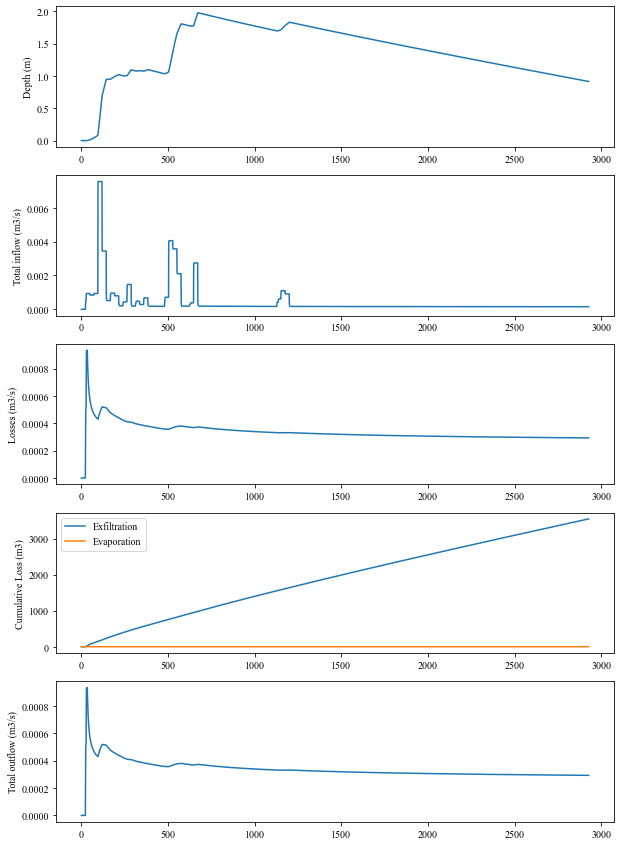

In [112]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10,15))
ax1.plot(SU_SWMM_TS[0].index,SU_SWMM_TS[0]["Depth (m)"] )
ax1.set_ylabel("Depth (m)")
ax2.plot(SU_SWMM_TS[0].index,SU_SWMM_TS[0]["Total inflow (m3/s)"] )
ax2.set_ylabel("Total inflow (m3/s)")
ax3.plot(SU_SWMM_TS[0].index,SU_SWMM_TS[0]["Losses (m3/s)"] )
ax3.set_ylabel("Losses (m3/s)")
ax4.plot(SU_SWMM_TS[0].index,SU_SWMM_TS[0]["Cumulative Exfiltration Loss (m3)"], label="Exfiltration" )
ax4.plot(SU_SWMM_TS[0].index,SU_SWMM_TS[0]["Cumulative Evaporation Loss (m3)"] , label="Evaporation")
ax4.set_ylabel("Cumulative Loss (m3)")
ax4.legend()
ax5.plot(SU_SWMM_TS[0].index,SU_SWMM_TS[0]["Total outflow (m3/s)"] )
ax5.set_ylabel("Total outflow (m3/s)")

## MODFLOW cells

<AxesSubplot:>

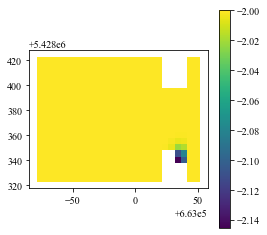

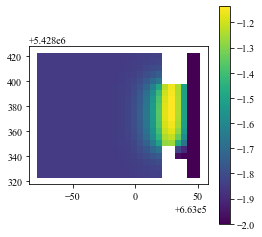

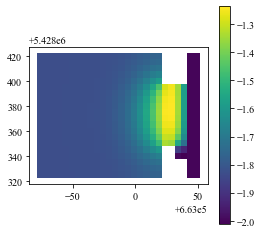

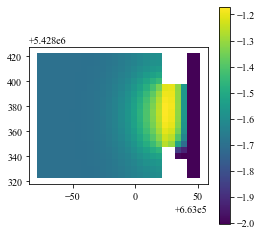

In [113]:
fig, ax1 = plt.subplots(1, 1 ,figsize=(4,4))
TS_gdf[0].plot(column='Altura', ax=ax1, legend=True)
fig, ax2 = plt.subplots(1, 1 ,figsize=(4,4))
TS_gdf[9].plot(column='Altura', ax=ax2, legend=True)
fig, ax3= plt.subplots(1, 1 ,figsize=(4,4))
TS_gdf[19].plot(column='Altura', ax=ax3, legend=True)
fig, ax4= plt.subplots(1, 1 ,figsize=(4,4))
TS_gdf[29].plot(column='Altura', ax=ax4, legend=True)

In [114]:
dias=np.linspace(0,len(TS_gdf)-1,len(TS_gdf))
W_inflow=[]
S_rch=[]
W_rch=[]
W_rch_neta=[]
for i in range(len(TS_gdf)):
    inflow=TS_gdf[i].groupby("SWMM_SU").sum()["DRN_rate"]  #m3/dia
    rch=TS_gdf[i].groupby("SWMM_S").sum()["RCH"]
    W_inflow.append(inflow.SU1)
    W_rch.append(rch.S2*x_resolution*y_resolution)
    S_rch.append(rch.S1*x_resolution*y_resolution)
    neta=rch.S2*x_resolution*y_resolution-inflow.SU1
    W_rch_neta.append(neta)
total_S_rch=sum(S_rch)
total_W_rch=sum(W_rch)
total_W_inflow=sum(W_inflow)
total_W_rch_neta=sum(W_rch_neta)

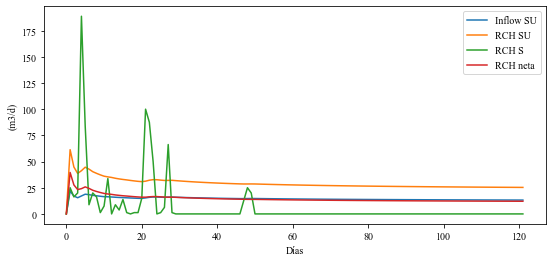

In [115]:
plt.figure(figsize=(9, 4))
plt.plot(dias, W_inflow, label="Inflow SU")
plt.plot(dias, W_rch, label="RCH SU")
plt.plot(dias, S_rch, label="RCH S")
plt.plot(dias, W_rch_neta, label="RCH neta")
plt.legend()
plt.ylabel("(m3/d)")
plt.xlabel("Días")
plt.show()

# Comparación con modelos desacoplados

## Uncouple Model

In [116]:
dire="SWMM_VER_model"
file="SWMM_VER_X2_Copy.inp"
path=dire + "/" + file

In [117]:
SU_SWMM_TS_SA=[]
S_SWMM_TS_SA=[]
for i in SU_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    a["Volume (m3)"]=""
    a["Losses (m3/s)"]=""
    a["Cumulative Exfiltration Loss (m3)"]=""
    SU_SWMM_TS_SA.append(a)
for i in S_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Precipitation (mm/h)"]=""
    a["Evaporation (mm/d)"]=""
    a["Infiltration (mm/h)"]="" 
    a["Runoff (m3/s)"]=""
    a["Runon (m3/s)"]=""
    a["Cumulative Infiltration (m3)"]=""
    a["Cumulative Evaporation (m3)"]=""
    S_SWMM_TS_SA.append(a)

In [118]:
with Simulation(path) as sim:
    S_list=[]
    SU_list=[]
    S_areas=[]
    system_routing = SystemStats(sim)
    
    for s in S_names_list:
        S_list.append(Subcatchments(sim)[s])
        S_areas.append(Subcatchments(sim)[s].area) #[ha]  
    for i in range(len(SU_names_list)):
        SU_list.append(Nodes(sim)[SU_names_list[i]])
    
    inf_S_list_1=np.zeros(len(S_list))
    inf_S_list_2=np.zeros(len(S_list))
    inf_SU_list_1=np.zeros(len(SU_list))
    inf_SU_list_2=np.zeros(len(SU_list))
    
    step_counter=0

    for step in sim:
        step_counter=step_counter+1
        
        #rainfall modification to avoid double counting
        
        if step_counter==12:
            step_counter=0
            
            #STORAGE UNITS TIME SERIES RESULTS
            for i in range(len(SU_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":SU_list[i].depth, 
                           "Head (m)":SU_list[i].head, "Flooding (m3/s)":SU_list[i].flooding, 
                           "Lateral inflow (m3/s)":SU_list[i].lateral_inflow,"Total inflow (m3/s)":SU_list[i].total_inflow,
                           "Total outflow (m3/s)":SU_list[i].total_outflow, "Volume (m3)":SU_list[i].volume, "Losses (m3/s)":SU_list[i].losses,
                           "Cumulative Exfiltration Loss (m3)": SU_list[i].storage_statistics["exfil_loss"]}
                SU_SWMM_TS_SA[i] =SU_SWMM_TS_SA[i].append(new_row, ignore_index=True)
            #SUBCATCHMENTS TIME SERIES RESULTS
            for i in range(len(S_list)):
                new_row = {'Time': sim.current_time, "Precipitation (mm/h)":S_list[i].rainfall, 
                           "Evaporation (mm/d)":S_list[i].evaporation_loss,"Infiltration (mm/h)":S_list[i].infiltration_loss, 
                           "Runoff (m3/s)":S_list[i].runoff,"Runon (m3/s)":S_list[i].runon,
                           "Cumulative Infiltration (m3)": S_list[i].statistics["infiltration"], "Cumulative Evaporation (m3)": S_list[i].statistics["evaporation"]}
                S_SWMM_TS_SA[i] =S_SWMM_TS_SA[i].append(new_row, ignore_index=True) 
    routing_stats_SA=system_routing.routing_stats
    runoff_stats_SA=system_routing.runoff_stats   

In [119]:
df_routing_SA = pd.DataFrame({'Dry Weather Inflow (m3)': [routing_stats_SA['dry_weather_inflow']],
                   'Wet Weather Inflow (m3)': [routing_stats_SA['wet_weather_inflow']], 
                   'Ground Water Inflow (m3)': [routing_stats_SA['groundwater_inflow']],
                   #'RDII Inflow (m3)': [routing_stats['II_inflow']],
                   'External Inflow (m3)': [routing_stats_SA['external_inflow']],
                   'External Outflow (m3)': [routing_stats_SA['outflow']],
                   'Flooding Loss (m3)': [routing_stats_SA['flooding']],
                   'Evaporation Loss (m3)': [routing_stats_SA['evaporation_loss']],
                   'Seepage Loss (m3)': [routing_stats_SA['seepage_loss']],
                   'Initial Stored Volume': [routing_stats_SA['initial_storage']],
                   'Final Stored Volume': [routing_stats_SA['final_storage']],
                   'Continuity Error (%)': [routing_stats_SA['routing_error']]})

In [120]:
df_runoff_SA = pd.DataFrame({'Total Precipitation (mm)': [runoff_stats_SA['rainfall']],
                   'Evaporation Loss (m3)': [runoff_stats_SA['evaporation']], 
                   'Infiltration Loss (m3)': [runoff_stats_SA['infiltration']],
                   'Runoff (m3)': [runoff_stats_SA['runoff']],
                   "Initial Storage (mm)":[runoff_stats_SA['init_storage']],
                   "Final Storage (mm)":[runoff_stats_SA['final_storage']]})

In [121]:
df_routing_SA

,Dry Weather Inflow (m3),Wet Weather Inflow (m3),Ground Water Inflow (m3),External Inflow (m3),External Outflow (m3),Flooding Loss (m3),Evaporation Loss (m3),Seepage Loss (m3),Initial Stored Volume,Final Stored Volume,Continuity Error (%)
0,0.0,2705.668666,0.0,0.0,0.0,0.0,0.0,2705.711389,0.0,32268.589275,0.0001


In [122]:
df_runoff_SA

,Total Precipitation (mm),Evaporation Loss (m3),Infiltration Loss (m3),Runoff (m3),Initial Storage (mm),Final Storage (mm)
0,334.5,137.975622,836.343486,2705.668666,0.0,0.0


## Uncouple Model with Ground Water Module

Características del modelo:

In [123]:
dire="SWMM_VER_model"
file="SWMM_VER_AS_X2.inp"
path=dire + "/" + file

In [124]:
S_SWMM_TS_GW=[]
SU_SWMM_TS_GW=[]
for i in S_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Precipitation (mm/h)"]=""
    a["Evaporation (mm/d)"]=""
    a["Infiltration (mm/h)"]="" 
    a["Runoff (m3/s)"]=""
    a["Runon (m3/s)"]=""
    a["Cumulative Infiltration (m3)"]=""
    a["Cumulative Evaporation (m3)"]=""
    S_SWMM_TS_GW.append(a)
for i in SU_names_list:
    a= pd.DataFrame()
    a["Time"]=""
    a["Depth (m)"]=""
    a["Head (m)"]=""
    a["Flooding (m3/s)"]=""
    a["Lateral inflow (m3/s)"]=""
    a["Total inflow (m3/s)"]=""
    a["Total outflow (m3/s)"]=""
    a["Volume (m3)"]=""
    a["Losses (m3/s)"]=""
    a["Cumulative Exfiltration Loss (m3)"]=""
    SU_SWMM_TS_GW.append(a)

In [125]:
with Simulation(path) as sim:
    S_list=[]
    SU_list=[]
    S_areas=[]
    system_routing = SystemStats(sim)
    
    for s in S_names_list:
        S_list.append(Subcatchments(sim)[s])
        S_areas.append(Subcatchments(sim)[s].area) #[ha]  
    for i in range(len(SU_names_list)):
        SU_list.append(Nodes(sim)[SU_names_list[i]])
    
    inf_S_list_1=np.zeros(len(S_list))
    inf_S_list_2=np.zeros(len(S_list))
    inf_SU_list_1=np.zeros(len(SU_list))
    inf_SU_list_2=np.zeros(len(SU_list))  
    
    step_counter=0

    for step in sim:
        step_counter=step_counter+1
        
        #rainfall modification to avoid double counting
        
        if step_counter==12:
            step_counter=0

            #STORAGE UNITS TIME SERIES RESULTS
            for i in range(len(SU_list)):
                new_row = {'Time': sim.current_time, "Depth (m)":SU_list[i].depth, 
                           "Head (m)":SU_list[i].head, "Flooding (m3/s)":SU_list[i].flooding, 
                           "Lateral inflow (m3/s)":SU_list[i].lateral_inflow,"Total inflow (m3/s)":SU_list[i].total_inflow,
                           "Total outflow (m3/s)":SU_list[i].total_outflow, "Volume (m3)":SU_list[i].volume, "Losses (m3/s)":SU_list[i].losses,
                           "Cumulative Exfiltration Loss (m3)": SU_list[i].storage_statistics["exfil_loss"]}
                SU_SWMM_TS_GW[i] =SU_SWMM_TS_GW[i].append(new_row, ignore_index=True)
            for i in range(len(S_list)):
                new_row = {'Time': sim.current_time, "Precipitation (mm/h)":S_list[i].rainfall, 
                           "Evaporation (mm/d)":S_list[i].evaporation_loss,"Infiltration (mm/h)":S_list[i].infiltration_loss, 
                           "Runoff (m3/s)":S_list[i].runoff,"Runon (m3/s)":S_list[i].runon,
                           "Cumulative Infiltration (m3)": S_list[i].statistics["infiltration"], "Cumulative Evaporation (m3)": S_list[i].statistics["evaporation"]}
                S_SWMM_TS_GW[i] =S_SWMM_TS_GW[i].append(new_row, ignore_index=True)
            
    routing_stats_GW=system_routing.routing_stats
    runoff_stats_GW=system_routing.runoff_stats     
print("Flow Routing Mass Balance Error:", sim.flow_routing_error)
print("Runoff Mass Balance Error:", sim.runoff_error)

Flow Routing Mass Balance Error: 0.0
Runoff Mass Balance Error: 0.0


In [126]:
df_routing_GW = pd.DataFrame({'Dry Weather Inflow (m3)': [routing_stats_GW['dry_weather_inflow']],
                   'Wet Weather Inflow (m3)': [routing_stats_GW['wet_weather_inflow']], 
                   'Ground Water Inflow (m3)': [routing_stats_GW['groundwater_inflow']],
                   #'RDII Inflow (m3)': [routing_stats['II_inflow']],
                   'External Inflow (m3)': [routing_stats_GW['external_inflow']],
                   'External Outflow (m3)': [routing_stats_GW['outflow']],
                   'Flooding Loss (m3)': [routing_stats_GW['flooding']],
                   'Evaporation Loss (m3)': [routing_stats_GW['evaporation_loss']],
                   'Seepage Loss (m3)': [routing_stats_GW['seepage_loss']],
                   'Initial Stored Volume': [routing_stats_GW['initial_storage']],
                   'Final Stored Volume': [routing_stats_GW['final_storage']],
                   'Continuity Error (%)': [routing_stats_GW['routing_error']]})

In [127]:
df_runoff_GW = pd.DataFrame({'Total Precipitation (mm)': [runoff_stats_GW['rainfall']],
                   'Evaporation Loss (m3)': [runoff_stats_GW['evaporation']], 
                   'Infiltration Loss (m3)': [runoff_stats_GW['infiltration']],
                   'Runoff (m3)': [runoff_stats_GW['runoff']],
                   "Initial Storage (mm)":[runoff_stats_GW['init_storage']],
                   "Final Storage (mm)":[runoff_stats_GW['final_storage']]})

In [128]:
df_routing_GW 

,Dry Weather Inflow (m3),Wet Weather Inflow (m3),Ground Water Inflow (m3),External Inflow (m3),External Outflow (m3),Flooding Loss (m3),Evaporation Loss (m3),Seepage Loss (m3),Initial Stored Volume,Final Stored Volume,Continuity Error (%)
0,0.0,2705.668666,-1526.619722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.157903


In [129]:
df_runoff_GW

,Total Precipitation (mm),Evaporation Loss (m3),Infiltration Loss (m3),Runoff (m3),Initial Storage (mm),Final Storage (mm)
0,334.5,137.975622,836.343486,2705.668666,0.0,0.0


## Gráficas de Comparación

### Storage Units

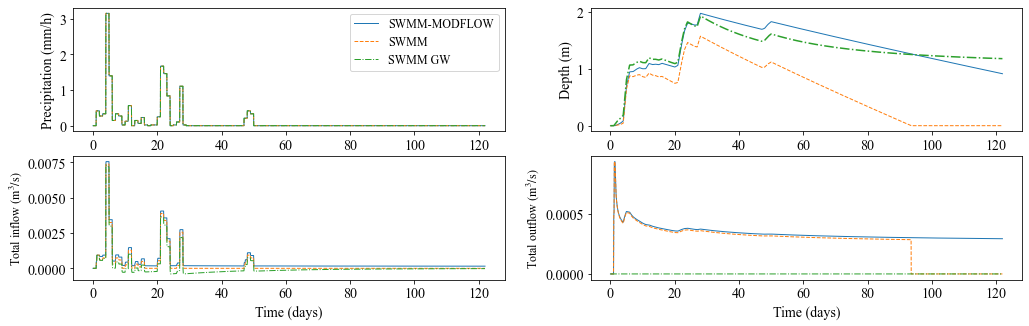

In [133]:
f, axs = plt.subplots(2,2, figsize=(17,5))

axs[1,0].plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Total inflow (m3/s)"],label="SWMM-MODFLOW",linestyle="-", linewidth=1)
axs[1,0].plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Total inflow (m3/s)"],label="SWMM",linestyle="--", linewidth=1)
axs[1,0].plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Total inflow (m3/s)"], label="SWMM GW", linestyle="-." , linewidth=1)
axs[1,0].set_ylabel("Total inflow $\mathrm{(m^3/s)}$",fontsize=12)
axs[1,0].set_xlabel("Time (days)")
axs[0,1].plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Depth (m)"], label="SWMM-MODFLOW",linestyle="-", linewidth=1)
axs[0,1].plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Depth (m)"], label="SWMM",linestyle="--", linewidth=1 )
axs[0,1].plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Depth (m)"], label="SWMM GW",linestyle="-." )
axs[0,1].set_ylabel("Depth (m)")

axs[0,0].plot(S_SWMM_TS[0].index/24,S_SWMM_TS[0]["Precipitation (mm/h)"], label="SWMM-MODFLOW",linestyle="-", linewidth=1)
axs[0,0].plot(S_SWMM_TS_SA[0].index/24,S_SWMM_TS_SA[0]["Precipitation (mm/h)"], label="SWMM",linestyle="--", linewidth=1)
axs[0,0].plot(S_SWMM_TS_GW[0].index/24,S_SWMM_TS_GW[0]["Precipitation (mm/h)"], label="SWMM GW", linestyle="-.", linewidth=1)
axs[0,0].set_ylabel("Precipitation (mm/h)")
axs[0,0].legend(fontsize=12)
# axs[0,1].plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Losses (m3/s)"],label="SWMM-MODFLOW",linestyle="-")
# axs[0,1].plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Losses (m3/s)"],label="SWMM",linestyle="--")
# axs[0,1].plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Losses (m3/s)"], label="SWMM GW", linestyle="-."  )
# axs[0,1].set_ylabel("Losses $[m^3/s]$")
# axs[0,1].legend()
# ax4.plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Cumulative Exfiltration Loss (m3)"],label="SWMM-MODFLOW",linestyle="-"  )
# ax4.plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Cumulative Exfiltration Loss (m3)"],label="SWMM",linestyle="--")
# ax4.plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Cumulative Exfiltration Loss (m3)"], label="SWMM GW", linestyle="-.")
# ax4.set_ylabel("Cumulative Exfiltration Loss (m3)")
axs[1,1].plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Total outflow (m3/s)"],label="SWMM-MODFLOW",linestyle="-", linewidth=1)
axs[1,1].plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Total outflow (m3/s)"],label="SWMM",linestyle="--", linewidth=1)
axs[1,1].plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Total outflow (m3/s)"], label="SWMM GW", linestyle="-.", linewidth=1)
axs[1,1].set_ylabel("Total outflow $\mathrm{(m^3/s)}$",fontsize=12)
axs[1,1].set_xlabel("Time (days)")

plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.savefig("Figuras\Time_Series_SU.svg")
plt.show()

In [134]:
SU_SWMM_TS_GW[0]["Total inflow (m3/s)"].describe()

count    2928.000000
mean        0.000112
std         0.000887
min        -0.000397
25%        -0.000175
50%        -0.000059
75%        -0.000026
max         0.007316
Name: Total inflow (m3/s), dtype: float64

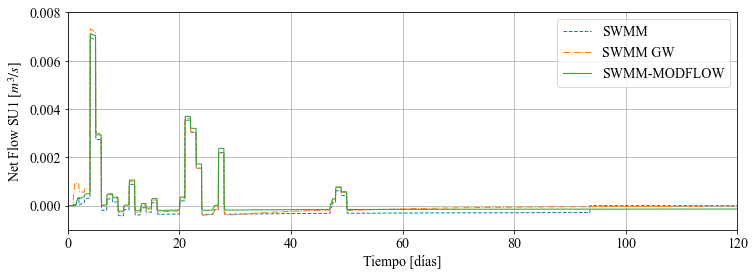

In [135]:
plt.figure(figsize=(12,4))
plt.plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Total inflow (m3/s)"]-SU_SWMM_TS_SA[0]["Total outflow (m3/s)"],label="SWMM",linestyle="--", linewidth=1)
plt.plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Total inflow (m3/s)"], label="SWMM GW", linestyle="-.", linewidth=1)
plt.plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Total inflow (m3/s)"]-SU_SWMM_TS[0]["Total outflow (m3/s)"], label="SWMM-MODFLOW",linestyle="-", linewidth=1)
plt.xlabel("Tiempo [días]")
plt.ylabel("Net Flow SU1 $[m^3/s]$")
plt.legend()
plt.ylim((-0.001,0.008))
plt.xlim((0,120))
plt.grid()
plt.savefig("Figuras\SU_TS_Net_Flow.svg")

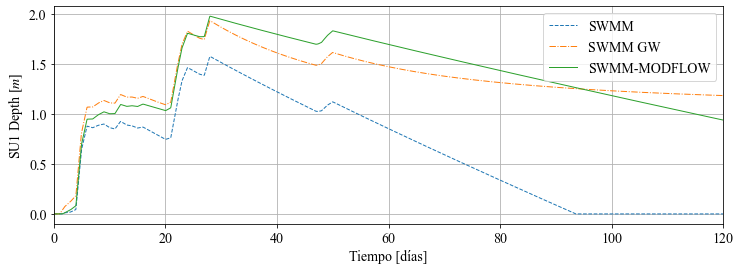

In [136]:
plt.figure(figsize=(12,4))
plt.plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Depth (m)"],label="SWMM",linestyle="--", linewidth=1)
plt.plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Depth (m)"], label="SWMM GW", linestyle="-.", linewidth=1 )
plt.plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Depth (m)"], label="SWMM-MODFLOW",linestyle="-", linewidth=1 )
plt.xlabel("Tiempo [días]")
plt.ylabel("SU1 Depth $[m]$")
plt.xlim((0,120))
plt.legend()
plt.grid()
plt.savefig("Figuras\SU_TS_Depth.svg")

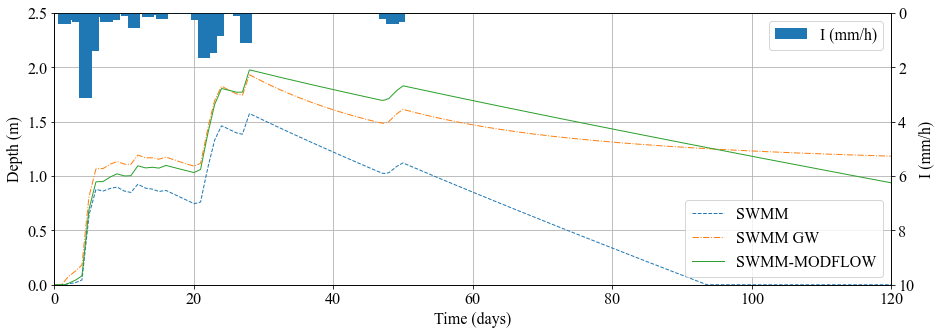

In [138]:
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Depth (m)"],label="SWMM",linestyle="--", linewidth=1)
ax.plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Depth (m)"], label="SWMM GW", linestyle="-.", linewidth=1 )
ax.plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Depth (m)"], label="SWMM-MODFLOW",linestyle="-", linewidth=1 )
ax.yaxis.set_label_text('Depth (m)')
ax.xaxis.set_label_text('Time (days)')
ax.set_ylim(0,2.5)
ax.set_xlim(0,120)
plt.grid()
ax2=ax.twinx()
ax2.bar(S_SWMM_TS[0].index/24,S_SWMM_TS[0]["Precipitation (mm/h)"], label="I (mm/h)")
ax2.set_ylim(0,10)
ax2.yaxis.set_label_text('I (mm/h)')
ax2.invert_yaxis()
ax.legend(loc="lower right")
ax2.legend(loc="upper right")
#plt.grid()
#ax.set_title("")

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

fig.savefig("Figuras/Fig4d_DepthTimeSeriesValidation.svg")

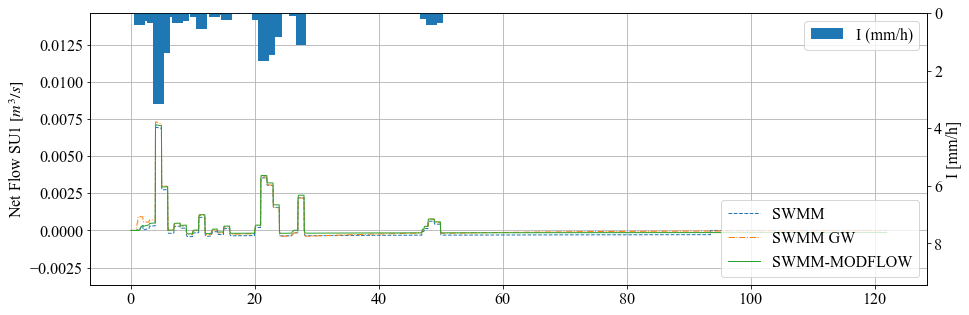

In [137]:
fig,ax=plt.subplots(figsize=(15,5))
plt.plot(SU_SWMM_TS_SA[0].index/24,SU_SWMM_TS_SA[0]["Total inflow (m3/s)"]-SU_SWMM_TS_SA[0]["Total outflow (m3/s)"],label="SWMM",linestyle="--", linewidth=1)
plt.plot(SU_SWMM_TS_GW[0].index/24,SU_SWMM_TS_GW[0]["Total inflow (m3/s)"], label="SWMM GW", linestyle="-.", linewidth=1)
plt.plot(SU_SWMM_TS[0].index/24,SU_SWMM_TS[0]["Total inflow (m3/s)"]-SU_SWMM_TS[0]["Total outflow (m3/s)"], label="SWMM-MODFLOW",linestyle="-", linewidth=1)
ax.yaxis.set_label_text("Net Flow SU1 $[m^3/s]$")
ax.set_ylim(-0.5*max(SU_SWMM_TS_GW[0]["Total inflow (m3/s)"]),2*max(SU_SWMM_TS_GW[0]["Total inflow (m3/s)"]))
plt.grid()
ax2=ax.twinx()
ax2.bar(S_SWMM_TS[0].index/24,S_SWMM_TS[0]["Precipitation (mm/h)"], label="I (mm/h)")
ax2.set_ylim(0,3*max(S_SWMM_TS[0]["Precipitation (mm/h)"]))
ax2.yaxis.set_label_text('I [mm/h]')
ax2.invert_yaxis()
ax.legend(loc="lower right")
ax2.legend(loc="upper right")
#plt.grid()
#ax.set_title("")

## Balances Globales

In [139]:
index=[["SWMM-MODFLOW", "SWMM", "SWMM-GW"]]

In [140]:
frames_routing = [df_routing_couple, df_routing_SA, df_routing_GW]

In [141]:
df_routing=pd.concat(frames_routing)

In [142]:
df_routing.set_index(index)

,Dry Weather Inflow (m3),Wet Weather Inflow (m3),Ground Water Inflow (m3),External Inflow (m3),External Outflow (m3),Flooding Loss (m3),Evaporation Loss (m3),Seepage Loss (m3),Initial Stored Volume,Final Stored Volume,Continuity Error (%)
SWMM-MODFLOW,0.0,2705.668666,0.000000,1755.152484,0.0,0.0,0.0,3546.974701,0.0,0.000000,0.000000
SWMM,0.0,2705.668666,0.000000,0.000000,0.0,0.0,0.0,2705.711389,0.0,32268.589275,0.000100
SWMM-GW,0.0,2705.668666,-1526.619722,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.157903


In [143]:
frames_runoff=[df_runoff_couple, df_runoff_SA, df_runoff_GW]

In [144]:
df_runoff=pd.concat(frames_runoff)

In [145]:
df_runoff.set_index(index)

,Total Precipitation (mm),Evaporation Loss (m3),Infiltration Loss (m3),Runoff (m3),Initial Storage (mm),Final Storage (mm)
SWMM-MODFLOW,334.5,137.975622,836.343486,2705.668666,0.0,0.0
SWMM,334.5,137.975622,836.343486,2705.668666,0.0,0.0
SWMM-GW,334.5,137.975622,836.343486,2705.668666,0.0,0.0


# Pruebas

## Seepage loss conduits SWMM model

In [ ]:
# #SWMM Subcatchments names:
# S_names_list=["S1", "S2"]
# #SWMM Storge Unites names:
# SU_names_list=["SU1"]
# #Wetlands subcatchments
# SU_S_names_list=["S2"]
# #SWMM conduits:
# C_names_list=["C1"]

Seepage off model

In [ ]:
# dire="SWMM_VER_model/otras_versiones"
# file="SWMM_VER_X2_SPoff.inp"
# path=dire + "/" + file

In [ ]:
# SU_SWMM_TS_SPoff=[]
# S_SWMM_TS_SPoff=[]
# C_SWMM_TS_SPoff=[]
# for i in SU_names_list:
#     a= pd.DataFrame()
#     a["Time"]=""
#     a["Depth (m)"]=""
#     a["Head (m)"]=""
#     a["Flooding (m3/s)"]=""
#     a["Lateral inflow (m3/s)"]=""
#     a["Total inflow (m3/s)"]=""
#     a["Total outflow (m3/s)"]=""
#     a["Volume (m3)"]=""
#     a["Losses (m3/s)"]=""
#     a["Cumulative Exfiltration Loss (m3)"]=""
#     SU_SWMM_TS_SPoff.append(a)
# for i in S_names_list:
#     a= pd.DataFrame()
#     a["Time"]=""
#     a["Precipitation (mm/h)"]=""
#     a["Evaporation (mm/d)"]=""
#     a["Infiltration (mm/h)"]="" 
#     a["Runoff (m3/s)"]=""
#     a["Runon (m3/s)"]=""
#     a["Cumulative Infiltration (m3)"]=""
#     a["Cumulative Evaporation (m3)"]=""
#     S_SWMM_TS_SPoff.append(a)
# for i in C_names_list:
#     a= pd.DataFrame()
#     a["Time"]=""
#     a["Depth (m)"]=""
#     a["Flow (m3/s)"]=""
#     a["ups xs area (m2)"]=""
#     a["ds xs area (m2)"]=""
#     a["Volume (m3)"]=""
#     #a["Seepage Loss ()"]=""
#     C_SWMM_TS_SPoff.append(a)

In [ ]:
# with Simulation(path) as sim:
#     S_list=[]
#     SU_list=[]
#     C_list=[]
#     S_areas=[]
#     system_routing = SystemStats(sim)
    
#     for s in S_names_list:
#         S_list.append(Subcatchments(sim)[s])
#         S_areas.append(Subcatchments(sim)[s].area) #[ha]  
#     for i in range(len(SU_names_list)):
#         SU_list.append(Nodes(sim)[SU_names_list[i]])
#     for c in range(len(C_names_list)):
#         C_list.append(Links(sim)[C_names_list[c]])
        
        
#     inf_S_list_1=np.zeros(len(S_list))
#     inf_S_list_2=np.zeros(len(S_list))
#     inf_SU_list_1=np.zeros(len(SU_list))
#     inf_SU_list_2=np.zeros(len(SU_list))
    
#     step_counter=0

#     for step in sim:
#         step_counter=step_counter+1
        
#         #rainfall modification to avoid double counting
        
#         if step_counter==12:
#             step_counter=0
            
#             #STORAGE UNITS TIME SERIES RESULTS
#             for i in range(len(SU_list)):
#                 new_row = {'Time': sim.current_time, "Depth (m)":SU_list[i].depth, 
#                            "Head (m)":SU_list[i].head, "Flooding (m3/s)":SU_list[i].flooding, 
#                            "Lateral inflow (m3/s)":SU_list[i].lateral_inflow,"Total inflow (m3/s)":SU_list[i].total_inflow,
#                            "Total outflow (m3/s)":SU_list[i].total_outflow, "Volume (m3)":SU_list[i].volume, "Losses (m3/s)":SU_list[i].losses,
#                            "Cumulative Exfiltration Loss (m3)": SU_list[i].storage_statistics["exfil_loss"]}
#                 SU_SWMM_TS_SPoff[i] =SU_SWMM_TS_SPoff[i].append(new_row, ignore_index=True)
#             #SUBCATCHMENTS TIME SERIES RESULTS
#             for i in range(len(S_list)):
#                 new_row = {'Time': sim.current_time, "Precipitation (mm/h)":S_list[i].rainfall, 
#                            "Evaporation (mm/d)":S_list[i].evaporation_loss,"Infiltration (mm/h)":S_list[i].infiltration_loss, 
#                            "Runoff (m3/s)":S_list[i].runoff,"Runon (m3/s)":S_list[i].runon,
#                            "Cumulative Infiltration (m3)": S_list[i].statistics["infiltration"], "Cumulative Evaporation (m3)": S_list[i].statistics["evaporation"]}
#                 S_SWMM_TS_SPoff[i] =S_SWMM_TS_SPoff[i].append(new_row, ignore_index=True) 
#             for i in range(len(C_list)):
#                 new_row= {'Time': sim.current_time, "Depth (m)": C_list[i].depth, "Flow (m3/s)": C_list[i].flow,
#                          "ups xs are (m2)":C_list[i].ups_xsection_area, "ds xs area (m2)":C_list[i].ds_xsection_area,
#                           "Volume (m3)":C_list[i].volume}
#                 C_SWMM_TS_SPoff[i] =C_SWMM_TS_SPoff[i].append(new_row, ignore_index=True)
            
#     routing_stats_SPoff=system_routing.routing_stats
#     runoff_stats_SPoff=system_routing.runoff_stats

In [ ]:
# df_routing_SPoff = pd.DataFrame({'Dry Weather Inflow (m3)': [routing_stats_SPoff['dry_weather_inflow']],
#                    'Wet Weather Inflow (m3)': [routing_stats_SPoff['wet_weather_inflow']], 
#                    'Ground Water Inflow (m3)': [routing_stats_SPoff['groundwater_inflow']],
#                    #'RDII Inflow (m3)': [routing_stats['II_inflow']],
#                    'External Inflow (m3)': [routing_stats_SPoff['external_inflow']],
#                    'External Outflow (m3)': [routing_stats_SPoff['outflow']],
#                    'Flooding Loss (m3)': [routing_stats_SPoff['flooding']],
#                    'Evaporation Loss (m3)': [routing_stats_SPoff['evaporation_loss']],
#                    'Seepage Loss (m3)': [routing_stats_SPoff['seepage_loss']],
#                    'Initial Stored Volume': [routing_stats_SPoff['initial_storage']],
#                    'Final Stored Volume': [routing_stats_SPoff['final_storage']],
#                    'Continuity Error (%)': [routing_stats_SPoff['routing_error']]})

In [ ]:
# df_runoff_SPoff = pd.DataFrame({'Total Precipitation (mm)': [runoff_stats_SPoff['rainfall']],
#                    'Evaporation Loss (m3)': [runoff_stats_SPoff['evaporation']], 
#                    'Infiltration Loss (m3)': [runoff_stats_SPoff['infiltration']],
#                    'Runoff (m3)': [runoff_stats_SPoff['runoff']],
#                    "Initial Storage (mm)":[runoff_stats_SPoff['init_storage']],
#                    "Final Storage (mm)":[runoff_stats_SPoff['final_storage']]})

Seepage on model

In [ ]:
# dire="SWMM_VER_model\otras_versiones"
# file="SWMM_VER_X2_SPon.inp"
# path=dire + "/" + file

In [ ]:
# SU_SWMM_TS_SPon=[]
# S_SWMM_TS_SPon=[]
# C_SWMM_TS_SPon=[]
# for i in SU_names_list:
#     a= pd.DataFrame()
#     a["Time"]=""
#     a["Depth (m)"]=""
#     a["Head (m)"]=""
#     a["Flooding (m3/s)"]=""
#     a["Lateral inflow (m3/s)"]=""
#     a["Total inflow (m3/s)"]=""
#     a["Total outflow (m3/s)"]=""
#     a["Volume (m3)"]=""
#     a["Losses (m3/s)"]=""
#     a["Cumulative Exfiltration Loss (m3)"]=""
#     SU_SWMM_TS_SPon.append(a)
# for i in S_names_list:
#     a= pd.DataFrame()
#     a["Time"]=""
#     a["Precipitation (mm/h)"]=""
#     a["Evaporation (mm/d)"]=""
#     a["Infiltration (mm/h)"]="" 
#     a["Runoff (m3/s)"]=""
#     a["Runon (m3/s)"]=""
#     a["Cumulative Infiltration (m3)"]=""
#     a["Cumulative Evaporation (m3)"]=""
#     S_SWMM_TS_SPon.append(a)
# for i in C_names_list:
#     a= pd.DataFrame()
#     a["Time"]=""
#     a["Depth (m)"]=""
#     a["Flow (m3/s)"]=""
#     a["ups xs area (m2)"]=""
#     a["ds xs area (m2)"]=""
#     a["Volume (m3)"]=""
#     #a["Seepage Loss ()"]=""
#     C_SWMM_TS_SPon.append(a)

In [ ]:
# with Simulation(path) as sim:
#     S_list=[]
#     SU_list=[]
#     S_areas=[]
#     C_list=[]
#     system_routing = SystemStats(sim)
    
#     for s in S_names_list:
#         S_list.append(Subcatchments(sim)[s])
#         S_areas.append(Subcatchments(sim)[s].area) #[ha]  
#     for i in range(len(SU_names_list)):
#         SU_list.append(Nodes(sim)[SU_names_list[i]])
#     for c in range(len(C_names_list)):
#         C_list.append(Links(sim)[C_names_list[c]])
    
#     inf_S_list_1=np.zeros(len(S_list))
#     inf_S_list_2=np.zeros(len(S_list))
#     inf_SU_list_1=np.zeros(len(SU_list))
#     inf_SU_list_2=np.zeros(len(SU_list))
    
#     step_counter=0

#     for step in sim:
#         step_counter=step_counter+1
        
#         #CONDUITS TIME SERIES RESULTS in every time step to calculate seepage loss
#         for i in range(len(C_list)):
#             new_row= {'Time': sim.current_time, "Depth (m)": C_list[i].depth, "Flow (m3/s)": C_list[i].flow,
#                     "ups xs area (m2)":C_list[i].ups_xsection_area, "ds xs area (m2)":C_list[i].ds_xsection_area,
#                     "Volume (m3)":C_list[i].volume}
#             C_SWMM_TS_SPon[i] =C_SWMM_TS_SPon[i].append(new_row, ignore_index=True)

#         if step_counter==12:
#             step_counter=0
            
#             #STORAGE UNITS TIME SERIES RESULTS
#             for i in range(len(SU_list)):
#                 new_row = {'Time': sim.current_time, "Depth (m)":SU_list[i].depth, 
#                            "Head (m)":SU_list[i].head, "Flooding (m3/s)":SU_list[i].flooding, 
#                            "Lateral inflow (m3/s)":SU_list[i].lateral_inflow,"Total inflow (m3/s)":SU_list[i].total_inflow,
#                            "Total outflow (m3/s)":SU_list[i].total_outflow, "Volume (m3)":SU_list[i].volume, "Losses (m3/s)":SU_list[i].losses,
#                            "Cumulative Exfiltration Loss (m3)": SU_list[i].storage_statistics["exfil_loss"]}
#                 SU_SWMM_TS_SPon[i] =SU_SWMM_TS_SPon[i].append(new_row, ignore_index=True)
#             #SUBCATCHMENTS TIME SERIES RESULTS
#             for i in range(len(S_list)):
#                 new_row = {'Time': sim.current_time, "Precipitation (mm/h)":S_list[i].rainfall, 
#                            "Evaporation (mm/d)":S_list[i].evaporation_loss,"Infiltration (mm/h)":S_list[i].infiltration_loss, 
#                            "Runoff (m3/s)":S_list[i].runoff,"Runon (m3/s)":S_list[i].runon,
#                            "Cumulative Infiltration (m3)": S_list[i].statistics["infiltration"], "Cumulative Evaporation (m3)": S_list[i].statistics["evaporation"]}
#                 S_SWMM_TS_SPon[i] =S_SWMM_TS_SPon[i].append(new_row, ignore_index=True) 
                
#     routing_stats_SPon=system_routing.routing_stats
#     runoff_stats_SPon=system_routing.runoff_stats   

In [ ]:
# with Simulation(path) as sim:
#     print(C_list[i].seepage_rate)

In [ ]:
# df_routing_SPon = pd.DataFrame({'Dry Weather Inflow (m3)': [routing_stats_SPon['dry_weather_inflow']],
#                    'Wet Weather Inflow (m3)': [routing_stats_SPon['wet_weather_inflow']], 
#                    'Ground Water Inflow (m3)': [routing_stats_SPon['groundwater_inflow']],
#                    #'RDII Inflow (m3)': [routing_stats['II_inflow']],
#                    'External Inflow (m3)': [routing_stats_SPon['external_inflow']],
#                    'External Outflow (m3)': [routing_stats_SPon['outflow']],
#                    'Flooding Loss (m3)': [routing_stats_SPon['flooding']],
#                    'Evaporation Loss (m3)': [routing_stats_SPon['evaporation_loss']],
#                    'Seepage Loss (m3)': [routing_stats_SPon['seepage_loss']],
#                    'Initial Stored Volume': [routing_stats_SPon['initial_storage']],
#                    'Final Stored Volume': [routing_stats_SPon['final_storage']],
#                    'Continuity Error (%)': [routing_stats_SPon['routing_error']]})

In [ ]:
# df_runoff_SPon = pd.DataFrame({'Total Precipitation (mm)': [runoff_stats_SPon['rainfall']],
#                    'Evaporation Loss (m3)': [runoff_stats_SPon['evaporation']], 
#                    'Infiltration Loss (m3)': [runoff_stats_SPon['infiltration']],
#                    'Runoff (m3)': [runoff_stats_SPon['runoff']],
#                    "Initial Storage (mm)":[runoff_stats_SPon['init_storage']],
#                    "Final Storage (mm)":[runoff_stats_SPon['final_storage']]})

In [ ]:
# df_routing_SPoff

In [ ]:
# df_routing_SPon

In [ ]:
# f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,10))
# ax1.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Depth (m)"], label="Seepage ON",linestyle="-" )
# ax1.plot(C_SWMM_TS_SPoff[0]["Time"],C_SWMM_TS_SPoff[0]["Depth (m)"], label="Seepage OFF",linestyle="--" )
# ax1.set_ylabel("Depth (m)")
# ax1.legend()
# ax2.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Flow (m3/s)"], label="Seepage ON",linestyle="-"  )
# ax2.plot(C_SWMM_TS_SPoff[0]["Time"],C_SWMM_TS_SPoff[0]["Flow (m3/s)"], label="Seepage OFF",linestyle="--"  )
# ax2.set_ylabel("Flow (m3/s)")
# ax2.legend()
# ax3.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["ups xs area (m2)"], label="ups",linestyle="-"  )
# ax3.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["ds xs area (m2)"], label="ds",linestyle="--"  )
# ax3.set_ylabel("Area (m2)")
# ax3.legend()
# ax4.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Volume (m3)"], label="Seepage ON",linestyle="-")
# ax4.plot(C_SWMM_TS_SPoff[0]["Time"],C_SWMM_TS_SPoff[0]["Volume (m3)"], label="Seepage OFF",linestyle="--"  )
# ax4.set_ylabel("Volume (m3)")
# ax4.legend()

In [ ]:
# f, (ax1, ax2, ax3,ax4, ax5) = plt.subplots(5,1, figsize=(10,10))
# ax1.plot(SU_SWMM_TS_SPon[0].index,SU_SWMM_TS_SPon[0]["Depth (m)"], label="SPon",linestyle="-" )
# ax1.plot(SU_SWMM_TS_SPoff[0].index,SU_SWMM_TS_SPoff[0]["Depth (m)"], label="SPoff",linestyle="--" )
# ax1.legend()
# ax1.set_ylabel("Depth (m)")
# ax2.plot(SU_SWMM_TS_SPon[0].index,SU_SWMM_TS_SPon[0]["Total inflow (m3/s)"],label="SPon",linestyle="--")
# ax2.plot(SU_SWMM_TS_SPoff[0].index,SU_SWMM_TS_SPoff[0]["Total inflow (m3/s)"], label="SPoff", linestyle="-."  )
# ax2.legend()
# ax2.set_ylabel("Total inflow (m3/s)")
# ax3.plot(SU_SWMM_TS_SPon[0].index,SU_SWMM_TS_SPon[0]["Losses (m3/s)"],label="SPon",linestyle="--")
# ax3.plot(SU_SWMM_TS_SPoff[0].index,SU_SWMM_TS_SPoff[0]["Losses (m3/s)"], label="SPoff", linestyle="-."  )
# ax3.legend()
# ax3.set_ylabel("Losses (m3/s)")
# ax4.plot(SU_SWMM_TS_SPon[0].index,SU_SWMM_TS_SPon[0]["Cumulative Exfiltration Loss (m3)"],label="SPon",linestyle="--")
# ax4.plot(SU_SWMM_TS_SPoff[0].index,SU_SWMM_TS_SPoff[0]["Cumulative Exfiltration Loss (m3)"], label="SPoff", linestyle="-.")
# ax4.legend()
# ax4.set_ylabel("Cumulative Exfiltration Loss (m3)")
# ax5.plot(SU_SWMM_TS_SPon[0].index,SU_SWMM_TS_SPon[0]["Total outflow (m3/s)"],label="SPon",linestyle="--")
# ax5.plot(SU_SWMM_TS_SPoff[0].index,SU_SWMM_TS_SPoff[0]["Total outflow (m3/s)"], label="SPoff", linestyle="-." )
# ax5.legend()
# ax5.set_ylabel("Total outflow (m3/s)")
# f.suptitle("Storage Unit Time Series",fontsize=16)
# plt.show()

Estimación Seepage Loss en Conductos:
- qs=s*W

Ojo que no puede ser mayor al volumen existente en el conducto

In [ ]:
# C_SWMM_TS_SPon[0]["Seepage (m3/s)"]=(C_SWMM_TS_SPon[0]["Depth (m)"]/C_SWMM_TS_SPon[0]["Depth (m)"])*100/1000/3600*0.1*50
# C_SWMM_TS_SPon[0]["Seepage (m3/s)"]=C_SWMM_TS_SPon[0]["Seepage (m3/s)"].fillna(0)

In [ ]:
# C_SWMM_TS_SPon[0]["Max Seepage dt (m3/s)"]=C_SWMM_TS_SPon[0]["Volume (m3)"]/300

In [ ]:
# f, (ax2) = plt.subplots(1,1, figsize=(20,5))
# ax2.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Seepage (m3/s)"], label="Seepage",linestyle="-"  )
# ax2.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Max Seepage dt (m3/s)"], label="Max Seepage",linestyle="--" )
# ax2.set_ylabel("Seepage (m3/s)")
# ax2.legend(loc="upper left")

In [ ]:
# C_SWMM_TS_SPon[0]["Final Seepage (m3/s)"]=C_SWMM_TS_SPon[0]["Seepage (m3/s)"]
# C_SWMM_TS_SPon[0].loc[C_SWMM_TS_SPon[0]["Seepage (m3/s)"]>C_SWMM_TS_SPon[0]["Max Seepage dt (m3/s)"], 'Final Seepage (m3/s)']=C_SWMM_TS_SPon[0]["Max Seepage dt (m3/s)"]

In [ ]:
# f, (ax2) = plt.subplots(1,1, figsize=(20,5))
# ax2.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Seepage (m3/s)"], label="Seepage",linestyle="-"  )
# ax2.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Max Seepage dt (m3/s)"], label="Max Seepage",linestyle="--" )
# ax2.plot(C_SWMM_TS_SPon[0]["Time"],C_SWMM_TS_SPon[0]["Final Seepage (m3/s)"], label="Final Seepage",linestyle="--" )
# ax2.set_ylabel("Seepage (m3/s)")
# ax2.legend(loc="upper left")

In [ ]:
# C_SWMM_TS_SPon[0]["Final Seepage (m3/s)"].sum()*300

In [ ]:
# C_SWMM_TS_SPon[0]["Seepage (m3/s)"].sum()*300

In [ ]:
# (df_routing_SPon["Seepage Loss (m3)"]-df_routing_SPoff["Seepage Loss (m3)"])

In [ ]:
# error_sp=((df_routing_SPon["Seepage Loss (m3)"]-df_routing_SPoff["Seepage Loss (m3)"])-C_SWMM_TS_SPon[0]["Final Seepage (m3/s)"].sum()*300)/(df_routing_SPon["Seepage Loss (m3)"]-df_routing_SPoff["Seepage Loss (m3)"])*100
# print(error_sp,"%")

In [ ]:
# with Simulation(path) as sim:
#     C1=Links(sim)["C1"]
#     print(C1.is_conduit())
#     print(C1.seepage_rate)